# 1. 导入库

In [1]:
import torch
from torch import nn
import time
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import os

# 2. 读取数据

In [3]:
# 训练集目录
TRAIN_DIRS = ['./dataset_torch/train1', './dataset_torch/train2', './dataset_torch/train3', './dataset_torch/train4', './dataset_torch/train5']
# 验证集目录
VAL_DIRS = ['./dataset_torch/val1', './dataset_torch/val2', './dataset_torch/val3', './dataset_torch/val4', './dataset_torch/val5']

# 解决中文显示问题
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 3. 图像增广

In [4]:
# 定义归一化转换，将像素值归一化到 [-1, 1] 之间
normalize = transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
input_shape = (3, 150, 150)
train_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    normalize  # 应用归一化
])

val_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    normalize  # 应用归一化
])

# 4. CUDA加速

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(3407)
if device =='cuda':
    torch.cuda.manual_seed_all(3407)

# 5.神经网络

## (1) CNN

In [9]:
class Cnn(nn.Module):
    def __init__(self, input_shape):
        super(Cnn, self).__init__()
        self.input_shape = input_shape

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape[0], out_channels=32, kernel_size=3, padding=0, stride = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(18496, 128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        return x.squeeze(1)

## (2) AlexNet

In [10]:
class AlexNet(nn.Module):
    def __init__(self, input_shape):
        super(AlexNet, self).__init__()
        self.input_shape = input_shape
        self.conv1 = nn.Conv2d(in_channels=input_shape[0], out_channels=32, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=4, stride=1, padding=1)  # 修改padding为1以保持输出尺寸
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2)
        # 计算全连接层的输入维度
        self.fc1 = nn.Linear(64 * 17 * 17, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 1)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)

        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.4, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=0.4, training=self.training)
        x = torch.sigmoid(self.fc3(x))
        return x.squeeze(1)

## (3) DNN

In [11]:
class DNNModel(nn.Module):
    def __init__(self, input_shape):
        super(DNNModel, self).__init__()
        self.input_shape = input_shape

        # First Convolutional Block
        self.conv1_1 = nn.Conv2d(in_channels=input_shape[0], out_channels=32, kernel_size=5, stride=1, padding=2)
        self.conv1_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(p=0.5)

        # Second Convolutional Block
        self.conv2_1 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.conv2_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(p=0.5)

        # Third Convolutional Block
        self.conv3_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv3_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout(p=0.5)

        # Fourth Convolutional Block
        self.conv4_1 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv4_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout4 = nn.Dropout(p=0.5)

        # Average Pooling
        self.avg_pool = nn.AvgPool2d(kernel_size=2, stride=2)

        # Fully Connected Layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 4 * 4, 1024)  # Corrected input dimension
        self.fc2 = nn.Linear(1024, 1)

    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = self.bn1(x)
        x = self.pool1(x)
        x = self.dropout1(x)

        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.bn2(x)
        x = self.pool2(x)
        x = self.dropout2(x)

        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = self.bn3(x)
        x = self.pool3(x)
        x = self.dropout3(x)

        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = self.bn4(x)
        x = self.pool4(x)
        x = self.dropout4(x)

        x = self.avg_pool(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x.squeeze(1)

## (4) Bilinear Model

In [6]:
class Bilinear (nn.Module):
    def __init__(self,input_shape):
        super(Bilinear, self).__init__()
        self.input_shape = input_shape

        self.features = nn.Sequential(

        # First Convolutional Block
        nn.Conv2d(in_channels=input_shape[0], out_channels=32, kernel_size=5, stride=1, padding=2),
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, stride=1, padding=2),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(p=0.5),

        # Second Convolutional Block
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding=2),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(p=0.5),

        # Third Convolutional Block
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(p=0.5),

        # Fourth Convolutional Block
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(p=0.5),

        # Average Pooling
        nn.AvgPool2d(kernel_size=2, stride=2),
        )

        self.classifiers = nn.Sequential(
            nn.Linear(128 ** 2, 1),
        )
    def forward(self, x):
        x = self.features(x)
        batch_size = x.size(0)

        x = x.view(batch_size, 128, 4 ** 2)##

        x = (torch.bmm(x, torch.transpose(x, 1, 2)) / 4 ** 2).view(batch_size, -1)

        x = torch.nn.functional.normalize(torch.sign(x) * torch.sqrt(torch.abs(x) + 1e-10))

        x = torch.sigmoid(self.classifiers(x))
        return x.squeeze(1)

# 6.训练函数

In [7]:
# 定义训练函数
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    loss, current, n = 0.0, 0.0, 0
    for batch, (x, y) in enumerate(dataloader):
        image, y = x.to(device), y.to(device).float()  # Ensure y is float
        output = model(image)
        cur_loss = loss_fn(output, y)
        cur_acc = torch.sum((y == output.round()).int()).float() / output.shape[0]

        # 反向传播
        optimizer.zero_grad()
        cur_loss.backward()
        optimizer.step()
        loss += cur_loss.item()
        current += cur_acc.item()
        n = n+1

    train_loss = loss / n
    train_acc = current / n
    print('train_loss: {:.4f}     train_acc: {:.4f}'.format(train_loss, train_acc))
    return train_loss, train_acc

# 7. 验证函数

In [8]:
def val(dataloader, model, loss_fn):
    # 将模型转化为验证模型
    model.eval()
    loss, current, n = 0.0, 0.0, 0
    with torch.no_grad():
        for batch, (x, y) in enumerate(dataloader):
            image, y = x.to(device), y.to(device).float()  # Ensure y is float
            output = model(image)
            cur_loss = loss_fn(output, y)
            cur_acc = torch.sum((y == output.round()).int()).float() / output.shape[0]
            loss += cur_loss.item()
            current += cur_acc.item()
            n = n + 1

    val_loss = loss / n
    val_acc = current / n
    print('val_loss: {:.4f}     val_acc: {:.4f}'.format(val_loss, val_acc))
    print()
    return val_loss, val_acc

# 8.画图

In [9]:
# 定义画图函数
def matplot_loss(train_loss, val_loss):
    plt.plot(train_loss, label='train_loss')
    plt.plot(val_loss, label='val_loss')
    plt.legend(loc='best')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.ylim(bottom=0)  # 设置y轴的最小值为0
    plt.xlim(left=0)    # 设置x轴的最小值为0，如果epoch从1开始，可以去掉这行
    plt.title("训练集和验证集loss值对比图")
    plt.show()

def matplot_acc(train_acc, val_acc):
    plt.plot(train_acc, label='train_acc')
    plt.plot(val_acc, label='val_acc')
    plt.legend(loc='best')
    plt.ylabel('acc')
    plt.xlabel('epoch')
    plt.ylim(bottom=0)  # 设置y轴的最小值为0
    plt.xlim(left=0)    # 设置x轴的最小值为0，如果epoch从1开始，可以去掉这行
    plt.title("训练集和验证集acc值对比图")
    plt.show()

# 9.开始训练

epoch1
-----------
train_loss: 0.6881     train_acc: 0.5325
val_loss: 0.6804     val_acc: 0.5875

save best model, 第1轮
epoch2
-----------
train_loss: 0.6626     train_acc: 0.5950
val_loss: 0.6513     val_acc: 0.6375

save best model, 第2轮
epoch3
-----------
train_loss: 0.6339     train_acc: 0.6400
val_loss: 0.6232     val_acc: 0.6650

save best model, 第3轮
epoch4
-----------
train_loss: 0.6009     train_acc: 0.6725
val_loss: 0.6104     val_acc: 0.6525

epoch5
-----------
train_loss: 0.5692     train_acc: 0.7025
val_loss: 0.6060     val_acc: 0.6800

save best model, 第5轮
epoch6
-----------
train_loss: 0.5624     train_acc: 0.7163
val_loss: 0.5859     val_acc: 0.7100

save best model, 第6轮
epoch7
-----------
train_loss: 0.5369     train_acc: 0.7331
val_loss: 0.5821     val_acc: 0.6750

epoch8
-----------
train_loss: 0.5264     train_acc: 0.7438
val_loss: 0.5808     val_acc: 0.7100

epoch9
-----------
train_loss: 0.4996     train_acc: 0.7550
val_loss: 0.5663     val_acc: 0.6975

epoch10
-----

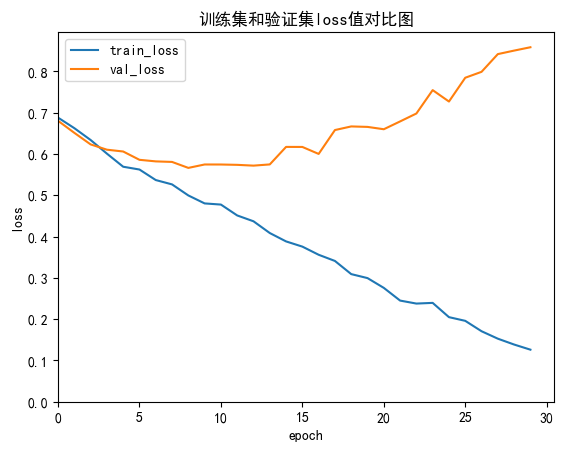

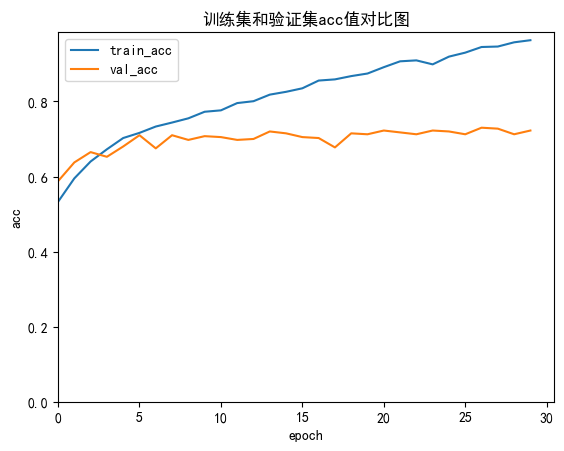

epoch1
-----------
train_loss: 0.6940     train_acc: 0.4994
val_loss: 0.6890     val_acc: 0.5875

save best model, 第1轮
epoch2
-----------
train_loss: 0.6818     train_acc: 0.5613
val_loss: 0.6758     val_acc: 0.5825

epoch3
-----------
train_loss: 0.6540     train_acc: 0.6175
val_loss: 0.6432     val_acc: 0.6150

save best model, 第3轮
epoch4
-----------
train_loss: 0.6245     train_acc: 0.6569
val_loss: 0.6211     val_acc: 0.6375

save best model, 第4轮
epoch5
-----------
train_loss: 0.5954     train_acc: 0.6987
val_loss: 0.5967     val_acc: 0.6925

save best model, 第5轮
epoch6
-----------
train_loss: 0.5725     train_acc: 0.7106
val_loss: 0.5940     val_acc: 0.6725

epoch7
-----------
train_loss: 0.5470     train_acc: 0.7275
val_loss: 0.5683     val_acc: 0.7200

save best model, 第7轮
epoch8
-----------
train_loss: 0.5207     train_acc: 0.7494
val_loss: 0.5636     val_acc: 0.7100

epoch9
-----------
train_loss: 0.5121     train_acc: 0.7569
val_loss: 0.5607     val_acc: 0.7250

save best mod

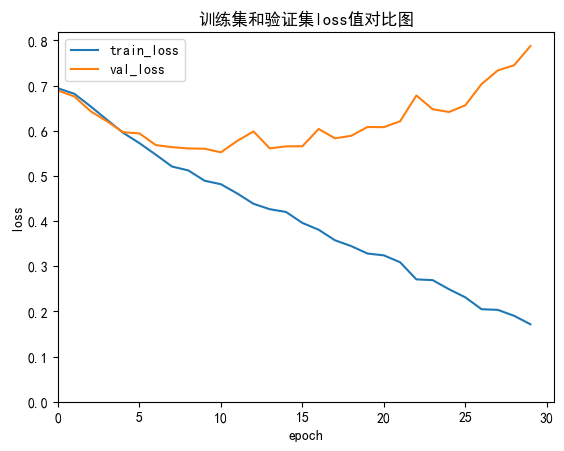

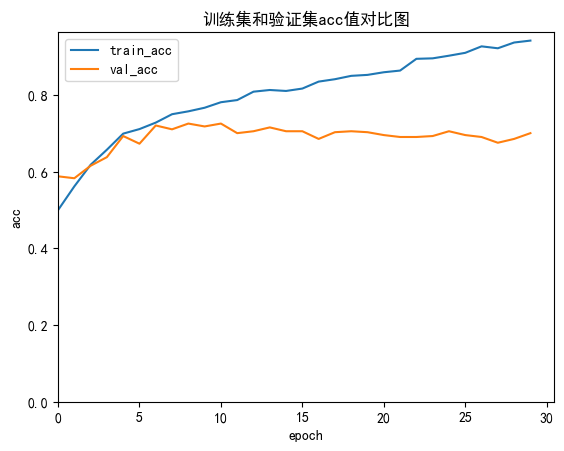

epoch1
-----------
train_loss: 0.6928     train_acc: 0.5244
val_loss: 0.6837     val_acc: 0.5500

save best model, 第1轮
epoch2
-----------
train_loss: 0.6783     train_acc: 0.5694
val_loss: 0.6619     val_acc: 0.6425

save best model, 第2轮
epoch3
-----------
train_loss: 0.6599     train_acc: 0.6056
val_loss: 0.6332     val_acc: 0.6625

save best model, 第3轮
epoch4
-----------
train_loss: 0.6351     train_acc: 0.6569
val_loss: 0.6141     val_acc: 0.6625

epoch5
-----------
train_loss: 0.6091     train_acc: 0.6687
val_loss: 0.5930     val_acc: 0.7125

save best model, 第5轮
epoch6
-----------
train_loss: 0.5941     train_acc: 0.6950
val_loss: 0.5851     val_acc: 0.7125

epoch7
-----------
train_loss: 0.5761     train_acc: 0.7119
val_loss: 0.5816     val_acc: 0.7125

epoch8
-----------
train_loss: 0.5579     train_acc: 0.7106
val_loss: 0.5565     val_acc: 0.7200

save best model, 第8轮
epoch9
-----------
train_loss: 0.5414     train_acc: 0.7281
val_loss: 0.5668     val_acc: 0.7075

epoch10
-----

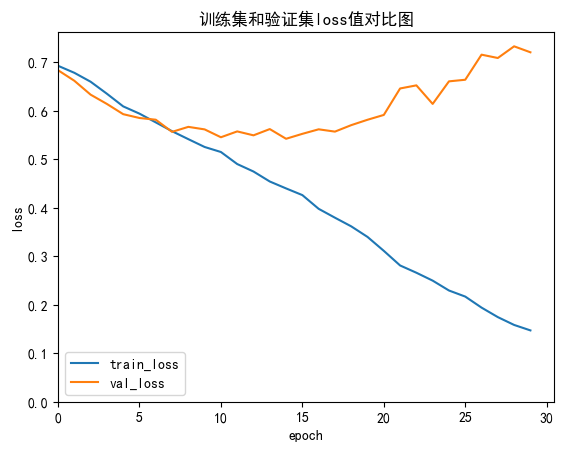

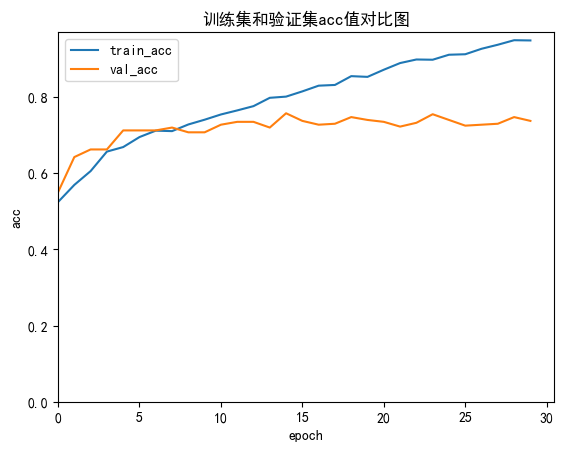

epoch1
-----------
train_loss: 0.6935     train_acc: 0.5056
val_loss: 0.6888     val_acc: 0.5350

save best model, 第1轮
epoch2
-----------
train_loss: 0.6784     train_acc: 0.5744
val_loss: 0.6657     val_acc: 0.6350

save best model, 第2轮
epoch3
-----------
train_loss: 0.6500     train_acc: 0.6344
val_loss: 0.6429     val_acc: 0.6525

save best model, 第3轮
epoch4
-----------
train_loss: 0.6138     train_acc: 0.6669
val_loss: 0.6123     val_acc: 0.6600

save best model, 第4轮
epoch5
-----------
train_loss: 0.5902     train_acc: 0.7069
val_loss: 0.6024     val_acc: 0.6625

save best model, 第5轮
epoch6
-----------
train_loss: 0.5584     train_acc: 0.7269
val_loss: 0.5844     val_acc: 0.6925

save best model, 第6轮
epoch7
-----------
train_loss: 0.5425     train_acc: 0.7294
val_loss: 0.5957     val_acc: 0.6700

epoch8
-----------
train_loss: 0.5330     train_acc: 0.7425
val_loss: 0.6124     val_acc: 0.6550

epoch9
-----------
train_loss: 0.4983     train_acc: 0.7806
val_loss: 0.5773     val_acc: 

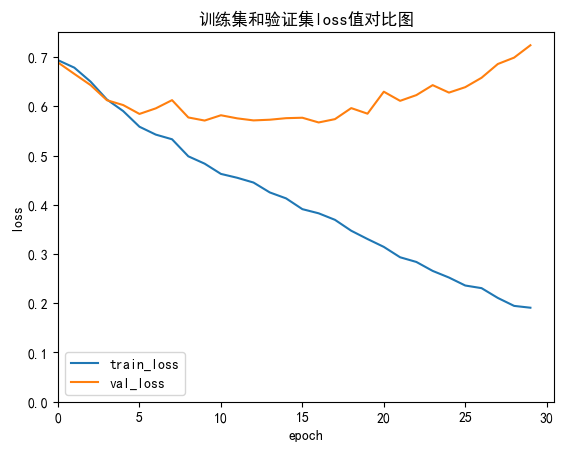

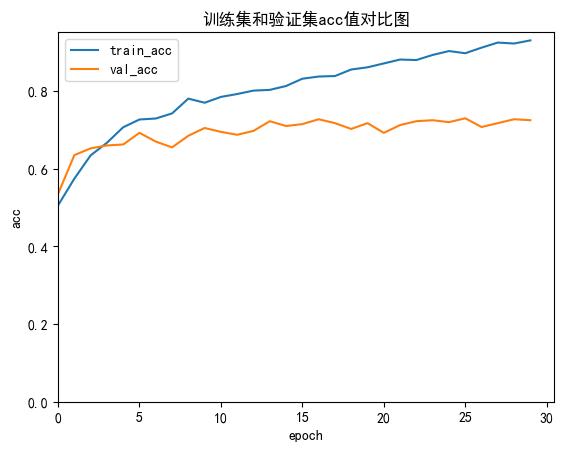

epoch1
-----------
train_loss: 0.6937     train_acc: 0.4950
val_loss: 0.6873     val_acc: 0.5075

save best model, 第1轮
epoch2
-----------
train_loss: 0.6733     train_acc: 0.5800
val_loss: 0.6572     val_acc: 0.6000

save best model, 第2轮
epoch3
-----------
train_loss: 0.6522     train_acc: 0.6019
val_loss: 0.6493     val_acc: 0.5700

epoch4
-----------
train_loss: 0.6378     train_acc: 0.6444
val_loss: 0.6309     val_acc: 0.6625

save best model, 第4轮
epoch5
-----------
train_loss: 0.6065     train_acc: 0.6713
val_loss: 0.6755     val_acc: 0.5525

epoch6
-----------
train_loss: 0.5978     train_acc: 0.6775
val_loss: 0.6002     val_acc: 0.6850

save best model, 第6轮
epoch7
-----------
train_loss: 0.5749     train_acc: 0.7144
val_loss: 0.6008     val_acc: 0.6975

save best model, 第7轮
epoch8
-----------
train_loss: 0.5687     train_acc: 0.7000
val_loss: 0.5889     val_acc: 0.7000

save best model, 第8轮
epoch9
-----------
train_loss: 0.5482     train_acc: 0.7256
val_loss: 0.5730     val_acc: 

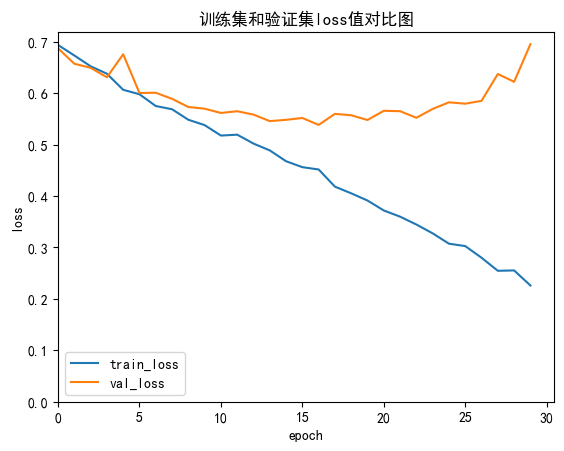

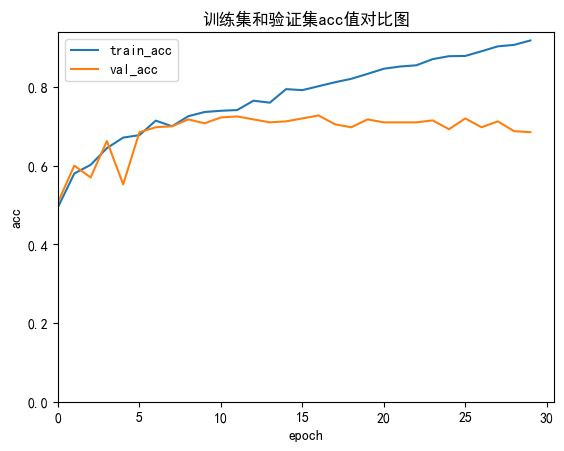


avg_train_loss: 0.3620     avg_train_acc: 0.8405
avg_val_loss: 0.6158     avg_val_acc: 0.7340
Done!


In [16]:
# 开始训练
all_loss_train = [0.0,0.0,0.0,0.0,0.0]
all_acc_train = [0.0,0.0,0.0,0.0,0.0]
all_loss_val = [0.0,0.0,0.0,0.0,0.0]
all_acc_val = [0.0,0.0,0.0,0.0,0.0]

avg_loss_train = 0
avg_acc_train = 0
avg_loss_val = 0
avg_acc_val = 0
#lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

for i in range (5):
#for i in range (1):
    start = time.time()
    model_Cnn = Cnn(input_shape).to(device)
    #model = AlexNet(input_shape).to(device)
    #model = DNNModel(input_shape).to(device)
    #model = Bilinear(input_shape).to(device)
    # 定义一个损失函数
    loss_fn = nn.BCELoss()
    # 定义一个优化器
    optimizer = torch.optim.Adam(model_Cnn.parameters(), lr=1e-4)
    # 学习率每隔10轮变为原来的0.5
    #lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    ROOT_TRAIN = TRAIN_DIRS[i]
    ROOT_TEST = VAL_DIRS[i]
    train_dataset = ImageFolder(ROOT_TRAIN, transform=train_transform)
    val_dataset = ImageFolder(ROOT_TEST, transform=val_transform)

    train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)
    loss_train = []
    acc_train = []
    loss_val = []
    acc_val = []

    epoch = 30
    min_acc = 0
    best_epoch = 0
    for t in range(epoch):
        print(f"epoch{t+1}\n-----------")
        train_loss, train_acc = train(train_dataloader, model_Cnn ,loss_fn, optimizer)
        val_loss, val_acc = val(val_dataloader, model_Cnn, loss_fn)

        loss_train.append(train_loss)
        acc_train.append(train_acc)
        loss_val.append(val_loss)
        acc_val.append(val_acc)

        # 保存最好的模型权重
        if val_acc >min_acc:
            folder = 'save_model'
            if not os.path.exists(folder):
                os.mkdir('save_model')
            all_acc_val[i] = val_acc
            all_loss_val[i] = val_loss
            all_acc_train[i] = train_acc
            all_loss_train[i] = train_loss

            min_acc = val_acc
            print(f"save best model, 第{t+1}轮")
            best_epoch = t
            torch.save(model_Cnn.state_dict(), 'save_model/best_cnn.pth')
        # 保存最后一轮的权重文件
        if t == epoch-1:
            torch.save(model_Cnn.state_dict(), 'save_model/last_cnn.pth')
        #lr_scheduler.step()
    end = time.time()
    all_time = end-start
    print("all_time",all_time)

    avg_acc_val += all_acc_val[i]
    avg_loss_val += all_loss_val[i]
    avg_acc_train += all_acc_train[i]
    avg_loss_train += all_loss_train[i]

    matplot_loss(loss_train, loss_val)
    matplot_acc(acc_train, acc_val)

print("")
print('avg_train_loss: {:.4f}     avg_train_acc: {:.4f}'.format(avg_loss_train/5, avg_acc_train/5))
print('avg_val_loss: {:.4f}     avg_val_acc: {:.4f}'.format(avg_loss_val/5, avg_acc_val/5))
print('Done!')

epoch1
-----------
train_loss: 0.6905     train_acc: 0.5431
val_loss: 0.6669     val_acc: 0.6225

save best model, 第1轮
epoch2
-----------
train_loss: 0.6423     train_acc: 0.6369
val_loss: 0.6207     val_acc: 0.6700

save best model, 第2轮
epoch3
-----------
train_loss: 0.5752     train_acc: 0.7031
val_loss: 0.5660     val_acc: 0.7275

save best model, 第3轮
epoch4
-----------
train_loss: 0.5212     train_acc: 0.7394
val_loss: 0.5681     val_acc: 0.6875

epoch5
-----------
train_loss: 0.4490     train_acc: 0.7950
val_loss: 0.5492     val_acc: 0.7525

save best model, 第5轮
epoch6
-----------
train_loss: 0.4019     train_acc: 0.8263
val_loss: 0.5135     val_acc: 0.7625

save best model, 第6轮
epoch7
-----------
train_loss: 0.3274     train_acc: 0.8619
val_loss: 0.5591     val_acc: 0.7500

epoch8
-----------
train_loss: 0.2691     train_acc: 0.8869
val_loss: 0.6085     val_acc: 0.7500

epoch9
-----------
train_loss: 0.2238     train_acc: 0.9094
val_loss: 0.5707     val_acc: 0.7450

epoch10
-----

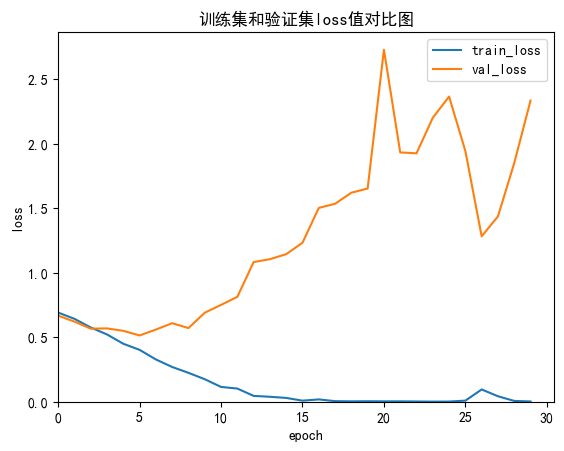

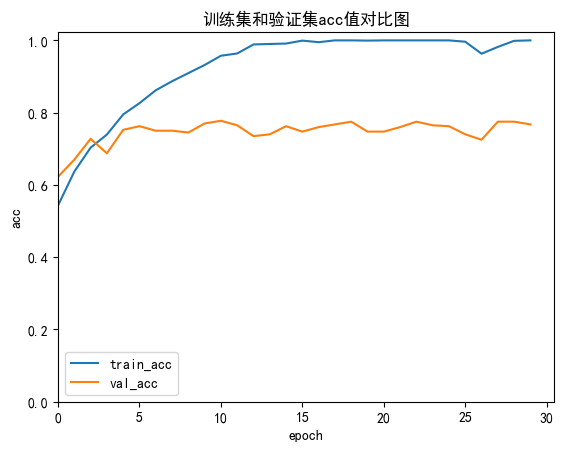

epoch1
-----------
train_loss: 0.6924     train_acc: 0.5337
val_loss: 0.6906     val_acc: 0.5050

save best model, 第1轮
epoch2
-----------
train_loss: 0.6529     train_acc: 0.6056
val_loss: 0.6033     val_acc: 0.6775

save best model, 第2轮
epoch3
-----------
train_loss: 0.5787     train_acc: 0.7031
val_loss: 0.5797     val_acc: 0.7125

save best model, 第3轮
epoch4
-----------
train_loss: 0.5149     train_acc: 0.7462
val_loss: 0.5867     val_acc: 0.6925

epoch5
-----------
train_loss: 0.4731     train_acc: 0.7800
val_loss: 0.5624     val_acc: 0.7225

save best model, 第5轮
epoch6
-----------
train_loss: 0.4096     train_acc: 0.8237
val_loss: 0.6048     val_acc: 0.7025

epoch7
-----------
train_loss: 0.3608     train_acc: 0.8425
val_loss: 0.5732     val_acc: 0.7475

save best model, 第7轮
epoch8
-----------
train_loss: 0.2683     train_acc: 0.8881
val_loss: 0.6178     val_acc: 0.7125

epoch9
-----------
train_loss: 0.1922     train_acc: 0.9213
val_loss: 0.7845     val_acc: 0.6850

epoch10
-----

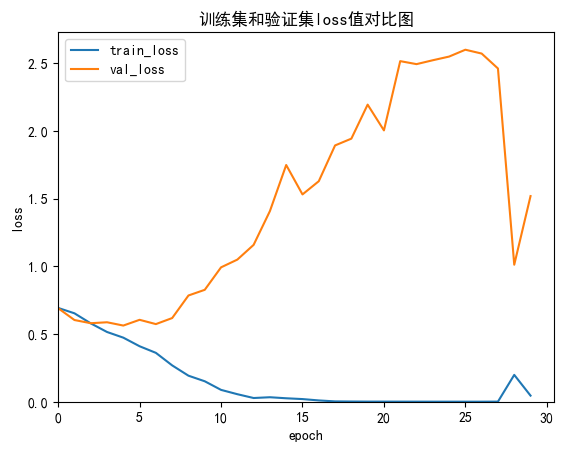

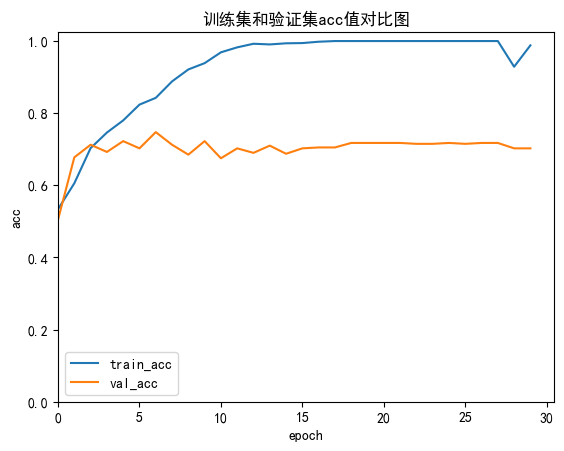

epoch1
-----------
train_loss: 0.6927     train_acc: 0.5025
val_loss: 0.6835     val_acc: 0.5050

save best model, 第1轮
epoch2
-----------
train_loss: 0.6559     train_acc: 0.6162
val_loss: 0.6113     val_acc: 0.6625

save best model, 第2轮
epoch3
-----------
train_loss: 0.5934     train_acc: 0.6900
val_loss: 0.5753     val_acc: 0.6950

save best model, 第3轮
epoch4
-----------
train_loss: 0.5244     train_acc: 0.7475
val_loss: 0.5887     val_acc: 0.7025

save best model, 第4轮
epoch5
-----------
train_loss: 0.4819     train_acc: 0.7688
val_loss: 0.5283     val_acc: 0.7400

save best model, 第5轮
epoch6
-----------
train_loss: 0.4050     train_acc: 0.8225
val_loss: 0.5137     val_acc: 0.7500

save best model, 第6轮
epoch7
-----------
train_loss: 0.3517     train_acc: 0.8438
val_loss: 0.5353     val_acc: 0.7475

epoch8
-----------
train_loss: 0.2850     train_acc: 0.8788
val_loss: 0.6321     val_acc: 0.7475

epoch9
-----------
train_loss: 0.2240     train_acc: 0.9075
val_loss: 0.7454     val_acc: 

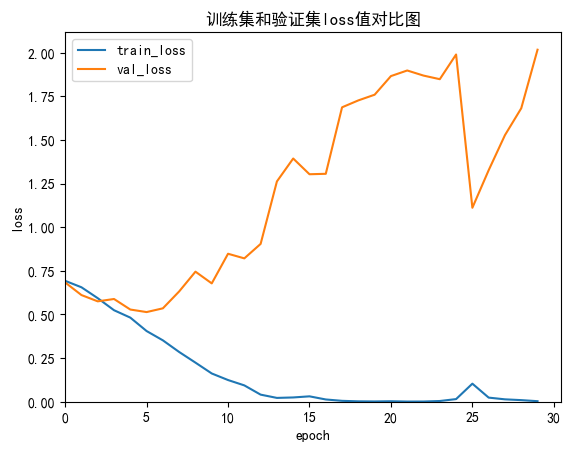

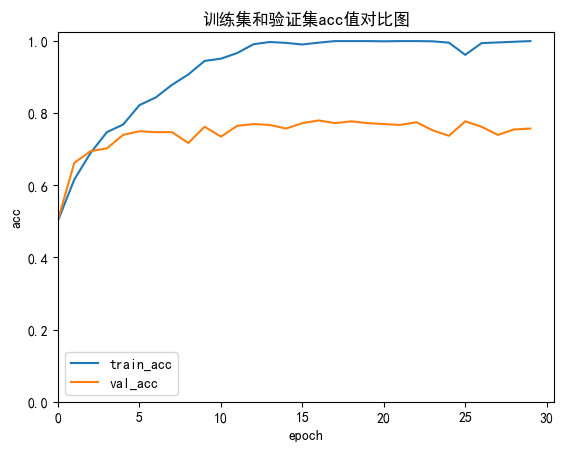

epoch1
-----------
train_loss: 0.6899     train_acc: 0.5294
val_loss: 0.6798     val_acc: 0.5375

save best model, 第1轮
epoch2
-----------
train_loss: 0.6316     train_acc: 0.6381
val_loss: 0.5979     val_acc: 0.6725

save best model, 第2轮
epoch3
-----------
train_loss: 0.5600     train_acc: 0.7194
val_loss: 0.5925     val_acc: 0.6950

save best model, 第3轮
epoch4
-----------
train_loss: 0.4961     train_acc: 0.7656
val_loss: 0.5464     val_acc: 0.7200

save best model, 第4轮
epoch5
-----------
train_loss: 0.4638     train_acc: 0.7825
val_loss: 0.5770     val_acc: 0.7125

epoch6
-----------
train_loss: 0.3929     train_acc: 0.8244
val_loss: 0.5555     val_acc: 0.7500

save best model, 第6轮
epoch7
-----------
train_loss: 0.3243     train_acc: 0.8600
val_loss: 0.6501     val_acc: 0.7250

epoch8
-----------
train_loss: 0.2557     train_acc: 0.8956
val_loss: 0.5964     val_acc: 0.7625

save best model, 第8轮
epoch9
-----------
train_loss: 0.1801     train_acc: 0.9256
val_loss: 0.6331     val_acc: 

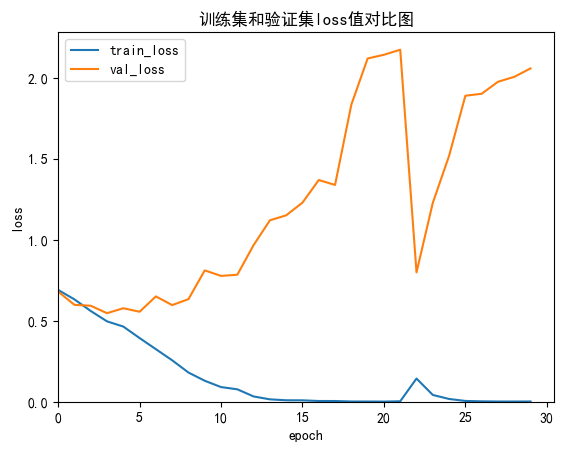

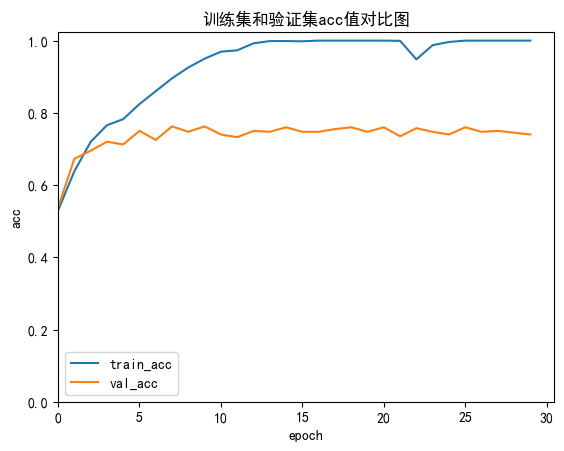

epoch1
-----------
train_loss: 0.6896     train_acc: 0.5437
val_loss: 0.6789     val_acc: 0.5350

save best model, 第1轮
epoch2
-----------
train_loss: 0.6469     train_acc: 0.6300
val_loss: 0.6585     val_acc: 0.5900

save best model, 第2轮
epoch3
-----------
train_loss: 0.6005     train_acc: 0.6719
val_loss: 0.6243     val_acc: 0.6475

save best model, 第3轮
epoch4
-----------
train_loss: 0.5482     train_acc: 0.7231
val_loss: 0.6066     val_acc: 0.6900

save best model, 第4轮
epoch5
-----------
train_loss: 0.4831     train_acc: 0.7781
val_loss: 0.5812     val_acc: 0.7075

save best model, 第5轮
epoch6
-----------
train_loss: 0.4325     train_acc: 0.8000
val_loss: 0.5482     val_acc: 0.7175

save best model, 第6轮
epoch7
-----------
train_loss: 0.3748     train_acc: 0.8400
val_loss: 0.5746     val_acc: 0.7200

save best model, 第7轮
epoch8
-----------
train_loss: 0.3340     train_acc: 0.8569
val_loss: 0.6934     val_acc: 0.6900

epoch9
-----------
train_loss: 0.2633     train_acc: 0.8931
val_loss:

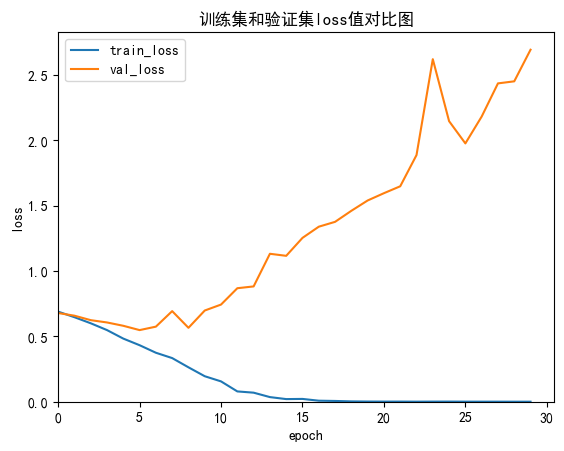

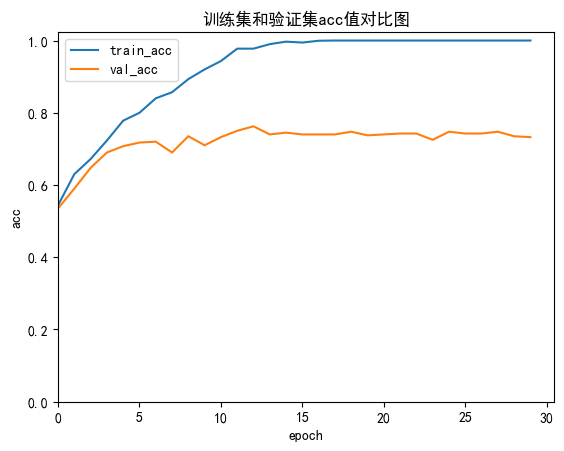


avg_train_loss: 0.1626     avg_train_acc: 0.9338
avg_val_loss: 0.8217     avg_val_acc: 0.7660
Done!


In [17]:
# 开始训练
all_loss_train = [0.0,0.0,0.0,0.0,0.0]
all_acc_train = [0.0,0.0,0.0,0.0,0.0]
all_loss_val = [0.0,0.0,0.0,0.0,0.0]
all_acc_val = [0.0,0.0,0.0,0.0,0.0]

avg_loss_train = 0
avg_acc_train = 0
avg_loss_val = 0
avg_acc_val = 0
#lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

for i in range (5):
#for i in range (1):
    start = time.time()
    #model = Cnn(input_shape).to(device)
    model_alex = AlexNet(input_shape).to(device)
    #model = DNNModel(input_shape).to(device)
    #model = Bilinear(input_shape).to(device)
    # 定义一个损失函数
    loss_fn = nn.BCELoss()
    # 定义一个优化器
    optimizer = torch.optim.Adam(model_alex.parameters(), lr=1e-4)
    # 学习率每隔10轮变为原来的0.5
    #lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    ROOT_TRAIN = TRAIN_DIRS[i]
    ROOT_TEST = VAL_DIRS[i]
    train_dataset = ImageFolder(ROOT_TRAIN, transform=train_transform)
    val_dataset = ImageFolder(ROOT_TEST, transform=val_transform)

    train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)
    loss_train = []
    acc_train = []
    loss_val = []
    acc_val = []

    epoch = 30
    min_acc = 0
    best_epoch = 0
    for t in range(epoch):
        print(f"epoch{t+1}\n-----------")
        train_loss, train_acc = train(train_dataloader, model_alex, loss_fn, optimizer)
        #lr_scheduler.step()
        val_loss, val_acc = val(val_dataloader, model_alex, loss_fn)

        loss_train.append(train_loss)
        acc_train.append(train_acc)
        loss_val.append(val_loss)
        acc_val.append(val_acc)

        # 保存最好的模型权重
        if val_acc >min_acc:
            folder = 'save_model'
            if not os.path.exists(folder):
                os.mkdir('save_model')
            all_acc_val[i] = val_acc
            all_loss_val[i] = val_loss
            all_acc_train[i] = train_acc
            all_loss_train[i] = train_loss

            min_acc = val_acc
            print(f"save best model, 第{t+1}轮")
            best_epoch = t
            torch.save(model_alex, 'save_model/best_alex.pth')
        # 保存最后一轮的权重文件
        if t == epoch-1:
            torch.save(model_alex, 'save_model/last_alex.pth')
    end = time.time()
    all_time = end-start
    print("all_time",all_time)

    avg_acc_val += all_acc_val[i]
    avg_loss_val += all_loss_val[i]
    avg_acc_train += all_acc_train[i]
    avg_loss_train += all_loss_train[i]

    matplot_loss(loss_train, loss_val)
    matplot_acc(acc_train, acc_val)

print("")
print('avg_train_loss: {:.4f}     avg_train_acc: {:.4f}'.format(avg_loss_train/5, avg_acc_train/5))
print('avg_val_loss: {:.4f}     avg_val_acc: {:.4f}'.format(avg_loss_val/5, avg_acc_val/5))
print('Done!')

epoch1
-----------
train_loss: 0.7252     train_acc: 0.5306
val_loss: 0.7300     val_acc: 0.5050

save best model, 第1轮
epoch2
-----------
train_loss: 0.6439     train_acc: 0.6238
val_loss: 0.8597     val_acc: 0.5125

save best model, 第2轮
epoch3
-----------
train_loss: 0.6278     train_acc: 0.6538
val_loss: 1.0558     val_acc: 0.5100

epoch4
-----------
train_loss: 0.5909     train_acc: 0.6894
val_loss: 1.1281     val_acc: 0.5250

save best model, 第4轮
epoch5
-----------
train_loss: 0.5586     train_acc: 0.7113
val_loss: 0.8952     val_acc: 0.5550

save best model, 第5轮
epoch6
-----------
train_loss: 0.5381     train_acc: 0.7356
val_loss: 1.0025     val_acc: 0.5425

epoch7
-----------
train_loss: 0.5108     train_acc: 0.7431
val_loss: 0.8021     val_acc: 0.6150

save best model, 第7轮
epoch8
-----------
train_loss: 0.4930     train_acc: 0.7612
val_loss: 0.7453     val_acc: 0.6125

epoch9
-----------
train_loss: 0.4558     train_acc: 0.7812
val_loss: 1.4377     val_acc: 0.5325

epoch10
-----

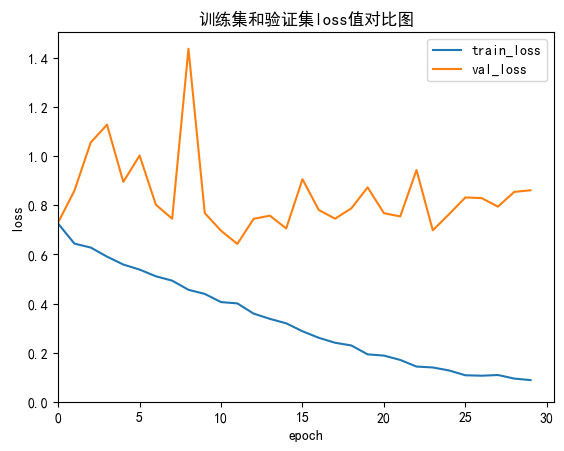

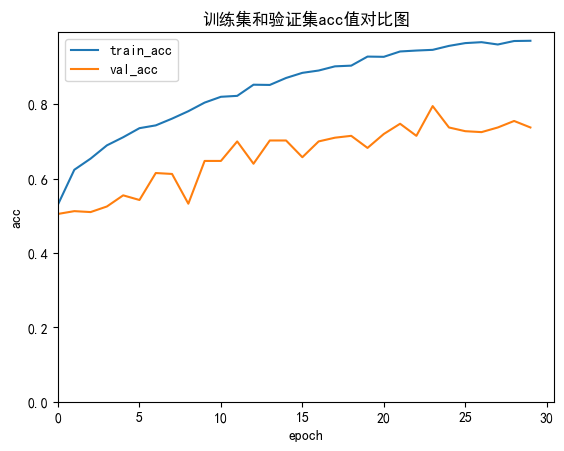

epoch1
-----------
train_loss: 0.6928     train_acc: 0.5663
val_loss: 0.8132     val_acc: 0.5025

save best model, 第1轮
epoch2
-----------
train_loss: 0.6338     train_acc: 0.6550
val_loss: 1.1900     val_acc: 0.5150

save best model, 第2轮
epoch3
-----------
train_loss: 0.5947     train_acc: 0.6837
val_loss: 0.9395     val_acc: 0.5850

save best model, 第3轮
epoch4
-----------
train_loss: 0.5854     train_acc: 0.6994
val_loss: 1.1783     val_acc: 0.5625

epoch5
-----------
train_loss: 0.5269     train_acc: 0.7425
val_loss: 0.9002     val_acc: 0.5900

save best model, 第5轮
epoch6
-----------
train_loss: 0.5310     train_acc: 0.7306
val_loss: 0.9012     val_acc: 0.5950

save best model, 第6轮
epoch7
-----------
train_loss: 0.4848     train_acc: 0.7588
val_loss: 0.9563     val_acc: 0.6100

save best model, 第7轮
epoch8
-----------
train_loss: 0.4685     train_acc: 0.7738
val_loss: 0.6507     val_acc: 0.6775

save best model, 第8轮
epoch9
-----------
train_loss: 0.4356     train_acc: 0.7919
val_loss:

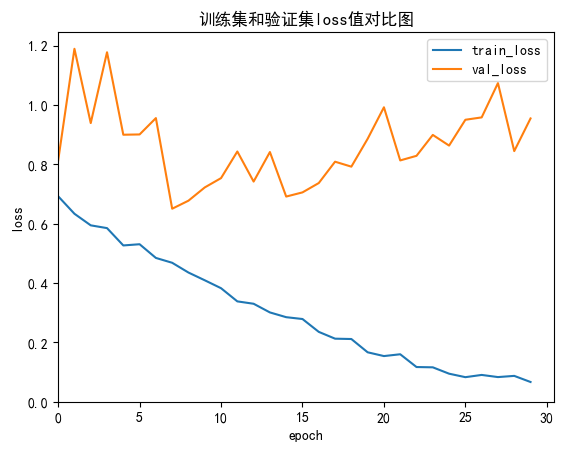

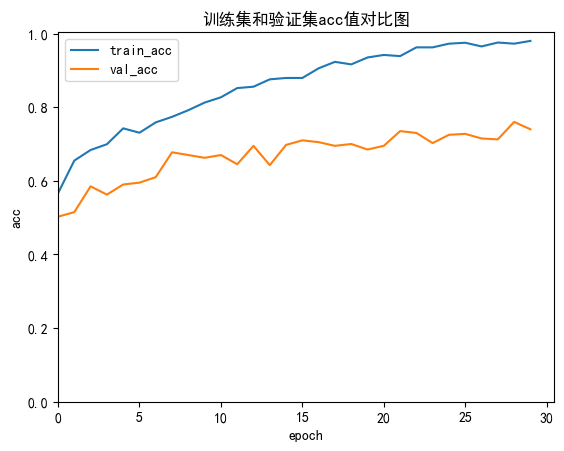

epoch1
-----------
train_loss: 0.7010     train_acc: 0.5750
val_loss: 0.9299     val_acc: 0.5000

save best model, 第1轮
epoch2
-----------
train_loss: 0.6619     train_acc: 0.6206
val_loss: 1.0673     val_acc: 0.5000

epoch3
-----------
train_loss: 0.6268     train_acc: 0.6637
val_loss: 0.9459     val_acc: 0.5050

save best model, 第3轮
epoch4
-----------
train_loss: 0.5880     train_acc: 0.6913
val_loss: 0.9188     val_acc: 0.5325

save best model, 第4轮
epoch5
-----------
train_loss: 0.5649     train_acc: 0.7063
val_loss: 0.6642     val_acc: 0.6250

save best model, 第5轮
epoch6
-----------
train_loss: 0.5266     train_acc: 0.7369
val_loss: 0.6962     val_acc: 0.6600

save best model, 第6轮
epoch7
-----------
train_loss: 0.5154     train_acc: 0.7400
val_loss: 0.7872     val_acc: 0.6025

epoch8
-----------
train_loss: 0.4816     train_acc: 0.7681
val_loss: 0.7991     val_acc: 0.6025

epoch9
-----------
train_loss: 0.4572     train_acc: 0.7987
val_loss: 0.8140     val_acc: 0.6450

epoch10
-----

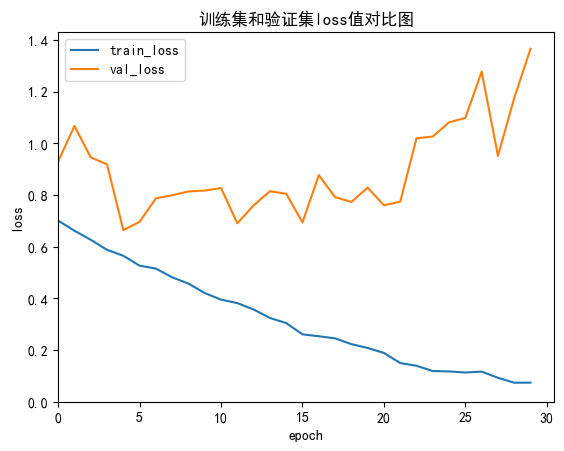

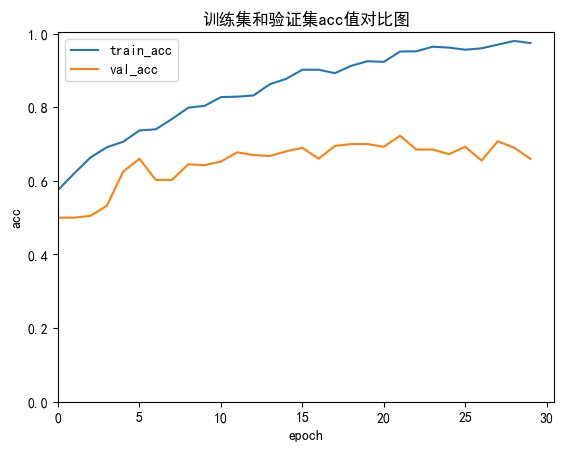

epoch1
-----------
train_loss: 0.6995     train_acc: 0.5506
val_loss: 0.8279     val_acc: 0.5050

save best model, 第1轮
epoch2
-----------
train_loss: 0.6528     train_acc: 0.6362
val_loss: 0.9183     val_acc: 0.5025

epoch3
-----------
train_loss: 0.6329     train_acc: 0.6481
val_loss: 0.8323     val_acc: 0.5550

save best model, 第3轮
epoch4
-----------
train_loss: 0.5918     train_acc: 0.6806
val_loss: 0.8700     val_acc: 0.5600

save best model, 第4轮
epoch5
-----------
train_loss: 0.5727     train_acc: 0.7044
val_loss: 0.7313     val_acc: 0.6125

save best model, 第5轮
epoch6
-----------
train_loss: 0.5276     train_acc: 0.7444
val_loss: 0.7541     val_acc: 0.6275

save best model, 第6轮
epoch7
-----------
train_loss: 0.4956     train_acc: 0.7525
val_loss: 0.8878     val_acc: 0.6100

epoch8
-----------
train_loss: 0.4695     train_acc: 0.7688
val_loss: 0.8495     val_acc: 0.6125

epoch9
-----------
train_loss: 0.4383     train_acc: 0.8000
val_loss: 0.8504     val_acc: 0.6200

epoch10
-----

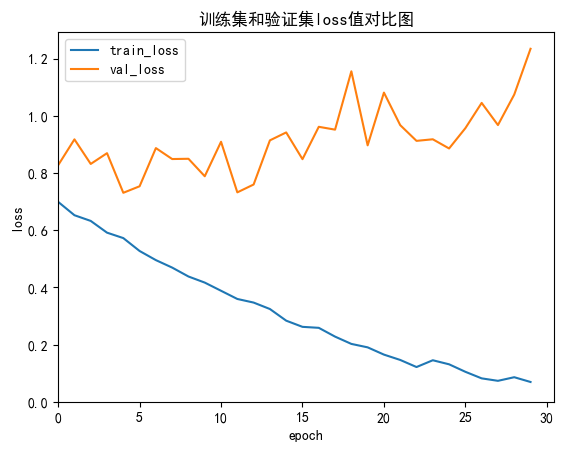

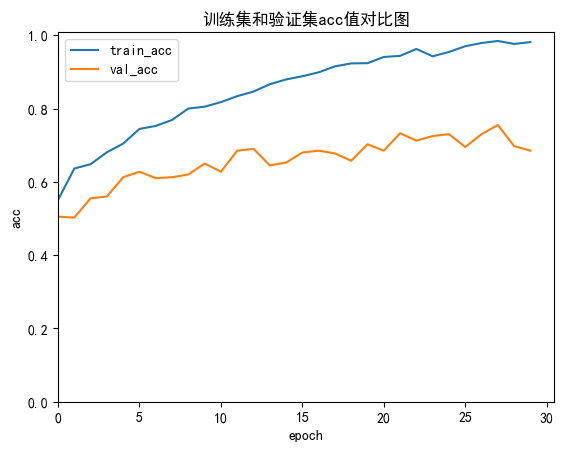

epoch1
-----------
train_loss: 0.6851     train_acc: 0.5781
val_loss: 0.8821     val_acc: 0.5000

save best model, 第1轮
epoch2
-----------
train_loss: 0.6412     train_acc: 0.6462
val_loss: 1.4798     val_acc: 0.5025

save best model, 第2轮
epoch3
-----------
train_loss: 0.5930     train_acc: 0.6844
val_loss: 0.6968     val_acc: 0.6125

save best model, 第3轮
epoch4
-----------
train_loss: 0.5675     train_acc: 0.7081
val_loss: 1.0237     val_acc: 0.5600

epoch5
-----------
train_loss: 0.5393     train_acc: 0.7206
val_loss: 0.7578     val_acc: 0.5925

epoch6
-----------
train_loss: 0.4953     train_acc: 0.7550
val_loss: 0.7886     val_acc: 0.6250

save best model, 第6轮
epoch7
-----------
train_loss: 0.4769     train_acc: 0.7712
val_loss: 0.6501     val_acc: 0.6775

save best model, 第7轮
epoch8
-----------
train_loss: 0.4584     train_acc: 0.7800
val_loss: 0.7596     val_acc: 0.6275

epoch9
-----------
train_loss: 0.4384     train_acc: 0.8019
val_loss: 0.6608     val_acc: 0.6950

save best mod

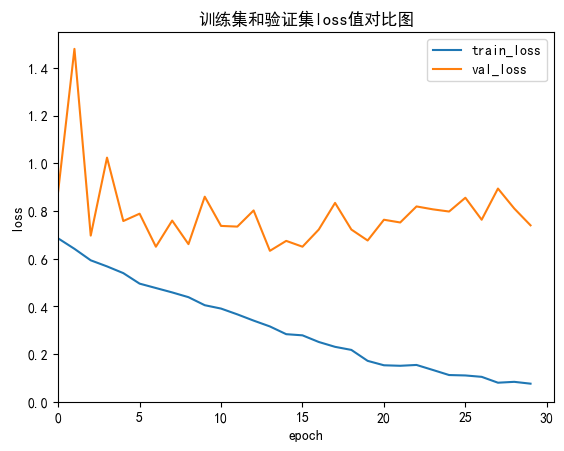

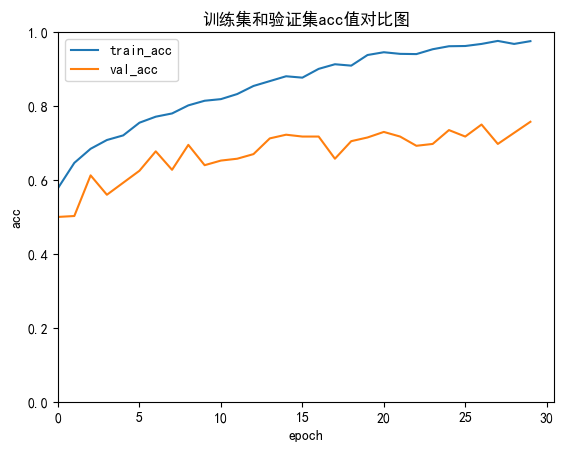


avg_train_loss: 0.1051     avg_train_acc: 0.9660
avg_val_loss: 0.8051     avg_val_acc: 0.7580
Done!


In [19]:
# 开始训练
all_loss_train = [0.0,0.0,0.0,0.0,0.0]
all_acc_train = [0.0,0.0,0.0,0.0,0.0]
all_loss_val = [0.0,0.0,0.0,0.0,0.0]
all_acc_val = [0.0,0.0,0.0,0.0,0.0]

avg_loss_train = 0
avg_acc_train = 0
avg_loss_val = 0
avg_acc_val = 0
#lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

for i in range (5):
#for i in range (1):
    start = time.time()
    #model = Cnn(input_shape).to(device)
    #model = AlexNet(input_shape).to(device)
    model_dnn = DNNModel(input_shape).to(device)
    #model = Bilinear(input_shape).to(device)
    # 定义一个损失函数
    loss_fn = nn.BCELoss()
    # 定义一个优化器
    optimizer = torch.optim.Adam(model_dnn.parameters(), lr=1e-4)
    # 学习率每隔10轮变为原来的0.5
    #lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    ROOT_TRAIN = TRAIN_DIRS[i]
    ROOT_TEST = VAL_DIRS[i]
    train_dataset = ImageFolder(ROOT_TRAIN, transform=train_transform)
    val_dataset = ImageFolder(ROOT_TEST, transform=val_transform)

    train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)
    loss_train = []
    acc_train = []
    loss_val = []
    acc_val = []

    epoch = 30
    min_acc = 0
    best_epoch = 0
    for t in range(epoch):
        print(f"epoch{t+1}\n-----------")
        train_loss, train_acc = train(train_dataloader, model_dnn, loss_fn, optimizer)
        #lr_scheduler.step()
        val_loss, val_acc = val(val_dataloader, model_dnn, loss_fn)

        loss_train.append(train_loss)
        acc_train.append(train_acc)
        loss_val.append(val_loss)
        acc_val.append(val_acc)

        # 保存最好的模型权重
        if val_acc >min_acc:
            folder = 'save_model'
            if not os.path.exists(folder):
                os.mkdir('save_model')
            all_acc_val[i] = val_acc
            all_loss_val[i] = val_loss
            all_acc_train[i] = train_acc
            all_loss_train[i] = train_loss

            min_acc = val_acc
            print(f"save best model, 第{t+1}轮")
            best_epoch = t
            torch.save(model_dnn, 'save_model/best_dnn.pth')
        # 保存最后一轮的权重文件
        if t == epoch-1:
            torch.save(model_dnn, 'save_model/last_dnn.pth')
    end = time.time()
    all_time = end-start
    print("all_time",all_time)

    avg_acc_val += all_acc_val[i]
    avg_loss_val += all_loss_val[i]
    avg_acc_train += all_acc_train[i]
    avg_loss_train += all_loss_train[i]

    matplot_loss(loss_train, loss_val)
    matplot_acc(acc_train, acc_val)

print("")
print('avg_train_loss: {:.4f}     avg_train_acc: {:.4f}'.format(avg_loss_train/5, avg_acc_train/5))
print('avg_val_loss: {:.4f}     avg_val_acc: {:.4f}'.format(avg_loss_val/5, avg_acc_val/5))
print('Done!')

epoch1
-----------
train_loss: 0.6917     train_acc: 0.5369
val_loss: 0.6928     val_acc: 0.5175

save best model, 第1轮
epoch2
-----------
train_loss: 0.6851     train_acc: 0.5725
val_loss: 0.6921     val_acc: 0.5075

epoch3
-----------
train_loss: 0.6755     train_acc: 0.6006
val_loss: 0.6874     val_acc: 0.5100

epoch4
-----------
train_loss: 0.6640     train_acc: 0.6200
val_loss: 0.6751     val_acc: 0.5900

save best model, 第4轮
epoch5
-----------
train_loss: 0.6549     train_acc: 0.6188
val_loss: 0.6644     val_acc: 0.5925

save best model, 第5轮
epoch6
-----------
train_loss: 0.6438     train_acc: 0.6406
val_loss: 0.6627     val_acc: 0.5825

epoch7
-----------
train_loss: 0.6334     train_acc: 0.6525
val_loss: 0.5914     val_acc: 0.7225

save best model, 第7轮
epoch8
-----------
train_loss: 0.6239     train_acc: 0.6625
val_loss: 0.6115     val_acc: 0.6750

epoch9
-----------
train_loss: 0.6136     train_acc: 0.6694
val_loss: 0.5935     val_acc: 0.6875

epoch10
-----------
train_loss: 0.

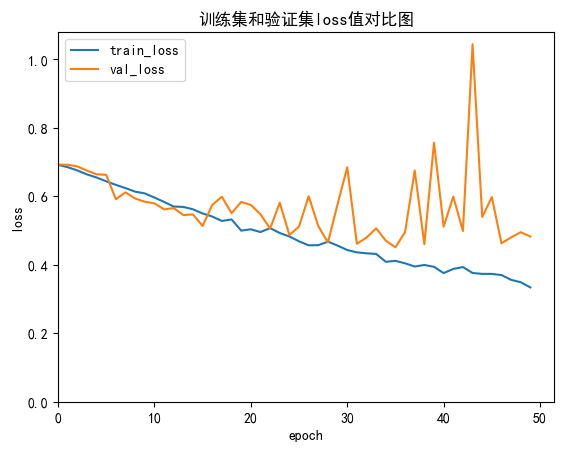

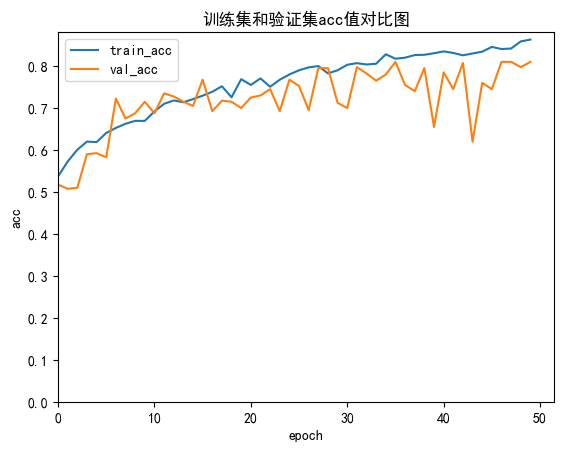

epoch1
-----------
train_loss: 0.6928     train_acc: 0.5150
val_loss: 0.6932     val_acc: 0.5200

save best model, 第1轮
epoch2
-----------
train_loss: 0.6896     train_acc: 0.5544
val_loss: 0.6919     val_acc: 0.5350

save best model, 第2轮
epoch3
-----------
train_loss: 0.6827     train_acc: 0.5694
val_loss: 0.6816     val_acc: 0.6075

save best model, 第3轮
epoch4
-----------
train_loss: 0.6745     train_acc: 0.5938
val_loss: 0.6663     val_acc: 0.6250

save best model, 第4轮
epoch5
-----------
train_loss: 0.6698     train_acc: 0.5988
val_loss: 0.6445     val_acc: 0.6775

save best model, 第5轮
epoch6
-----------
train_loss: 0.6605     train_acc: 0.6069
val_loss: 0.6321     val_acc: 0.7000

save best model, 第6轮
epoch7
-----------
train_loss: 0.6480     train_acc: 0.6344
val_loss: 0.6374     val_acc: 0.6525

epoch8
-----------
train_loss: 0.6402     train_acc: 0.6456
val_loss: 0.6150     val_acc: 0.6825

epoch9
-----------
train_loss: 0.6284     train_acc: 0.6469
val_loss: 0.6826     val_acc: 

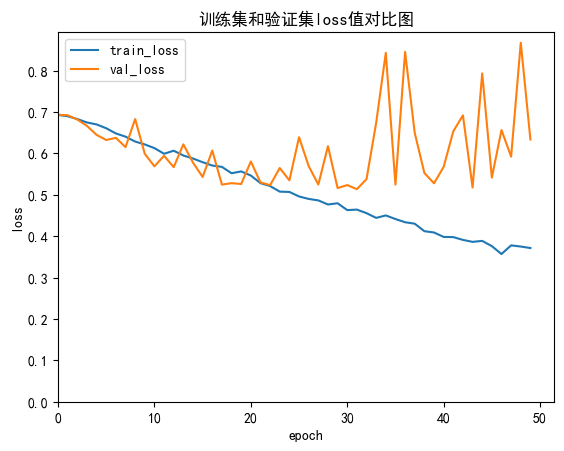

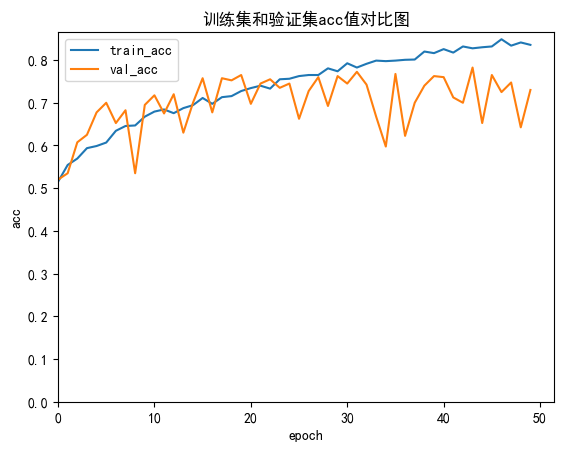

epoch1
-----------
train_loss: 0.6910     train_acc: 0.5350
val_loss: 0.6942     val_acc: 0.5000

save best model, 第1轮
epoch2
-----------
train_loss: 0.6854     train_acc: 0.5663
val_loss: 0.6843     val_acc: 0.5975

save best model, 第2轮
epoch3
-----------
train_loss: 0.6814     train_acc: 0.5756
val_loss: 0.6848     val_acc: 0.5650

epoch4
-----------
train_loss: 0.6682     train_acc: 0.6069
val_loss: 0.6886     val_acc: 0.5250

epoch5
-----------
train_loss: 0.6596     train_acc: 0.6206
val_loss: 0.6499     val_acc: 0.6450

save best model, 第5轮
epoch6
-----------
train_loss: 0.6496     train_acc: 0.6312
val_loss: 0.6360     val_acc: 0.6450

epoch7
-----------
train_loss: 0.6358     train_acc: 0.6450
val_loss: 0.6254     val_acc: 0.6600

save best model, 第7轮
epoch8
-----------
train_loss: 0.6236     train_acc: 0.6550
val_loss: 0.6132     val_acc: 0.6650

save best model, 第8轮
epoch9
-----------
train_loss: 0.6205     train_acc: 0.6656
val_loss: 0.6305     val_acc: 0.6425

epoch10
-----

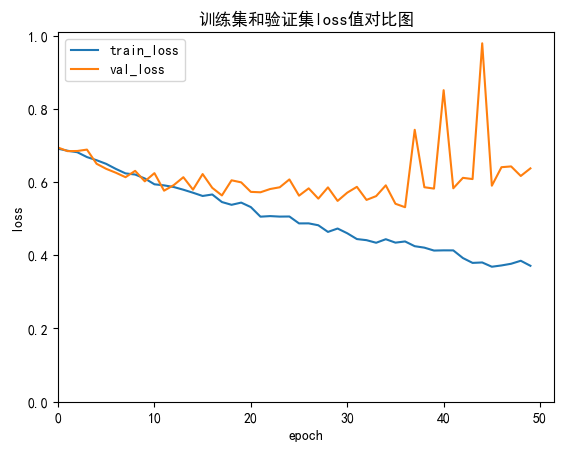

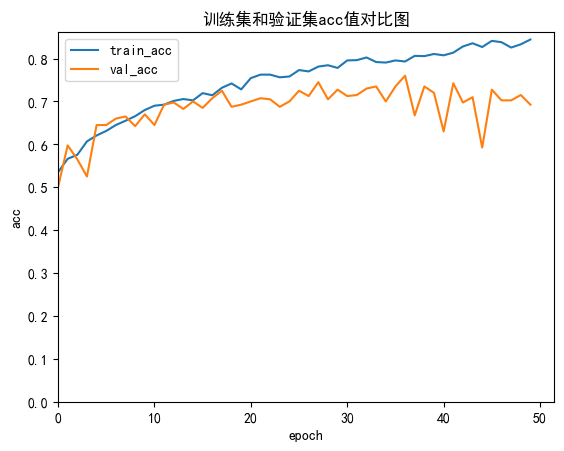

epoch1
-----------
train_loss: 0.6897     train_acc: 0.5425
val_loss: 0.6947     val_acc: 0.5050

save best model, 第1轮
epoch2
-----------
train_loss: 0.6889     train_acc: 0.5400
val_loss: 0.6935     val_acc: 0.5300

save best model, 第2轮
epoch3
-----------
train_loss: 0.6826     train_acc: 0.5813
val_loss: 0.6927     val_acc: 0.5025

epoch4
-----------
train_loss: 0.6846     train_acc: 0.5581
val_loss: 0.6799     val_acc: 0.5975

save best model, 第4轮
epoch5
-----------
train_loss: 0.6751     train_acc: 0.5806
val_loss: 0.6614     val_acc: 0.6300

save best model, 第5轮
epoch6
-----------
train_loss: 0.6586     train_acc: 0.6244
val_loss: 0.6449     val_acc: 0.6575

save best model, 第6轮
epoch7
-----------
train_loss: 0.6446     train_acc: 0.6550
val_loss: 0.6661     val_acc: 0.6050

epoch8
-----------
train_loss: 0.6309     train_acc: 0.6506
val_loss: 0.6427     val_acc: 0.6375

epoch9
-----------
train_loss: 0.6231     train_acc: 0.6538
val_loss: 0.6262     val_acc: 0.6450

epoch10
-----

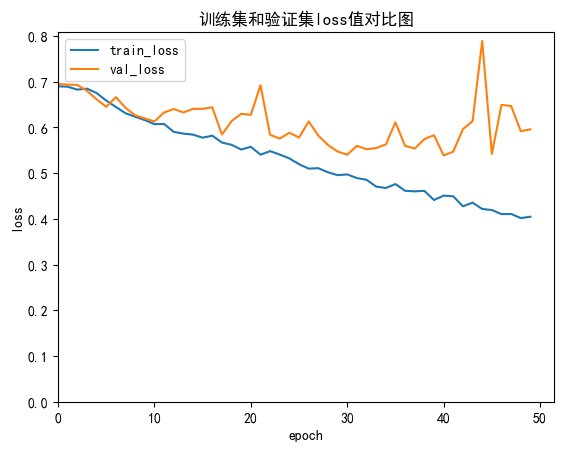

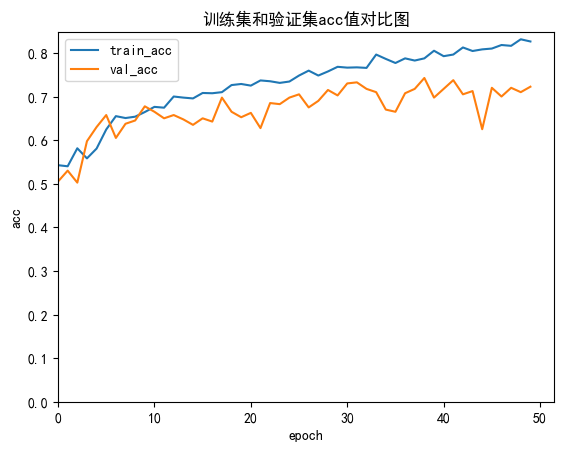

epoch1
-----------
train_loss: 0.6907     train_acc: 0.5413
val_loss: 0.6927     val_acc: 0.4975

save best model, 第1轮
epoch2
-----------
train_loss: 0.6873     train_acc: 0.5550
val_loss: 0.6898     val_acc: 0.5425

save best model, 第2轮
epoch3
-----------
train_loss: 0.6790     train_acc: 0.5875
val_loss: 0.6832     val_acc: 0.5800

save best model, 第3轮
epoch4
-----------
train_loss: 0.6722     train_acc: 0.5969
val_loss: 0.6803     val_acc: 0.5800

epoch5
-----------
train_loss: 0.6647     train_acc: 0.6144
val_loss: 0.6846     val_acc: 0.5550

epoch6
-----------
train_loss: 0.6597     train_acc: 0.6250
val_loss: 0.6781     val_acc: 0.5850

save best model, 第6轮
epoch7
-----------
train_loss: 0.6541     train_acc: 0.6169
val_loss: 0.6678     val_acc: 0.6100

save best model, 第7轮
epoch8
-----------
train_loss: 0.6408     train_acc: 0.6388
val_loss: 0.6571     val_acc: 0.5925

epoch9
-----------
train_loss: 0.6368     train_acc: 0.6462
val_loss: 0.6575     val_acc: 0.6075

epoch10
-----

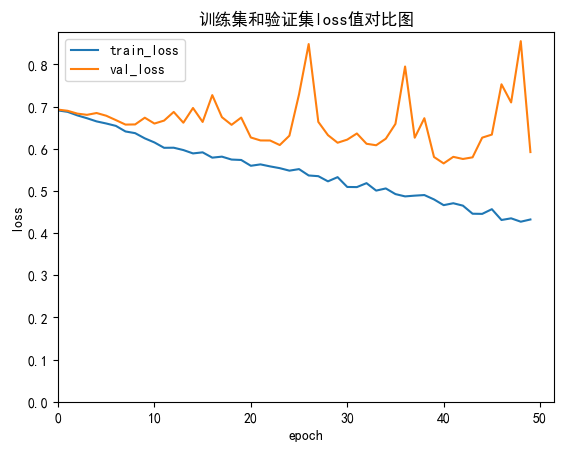

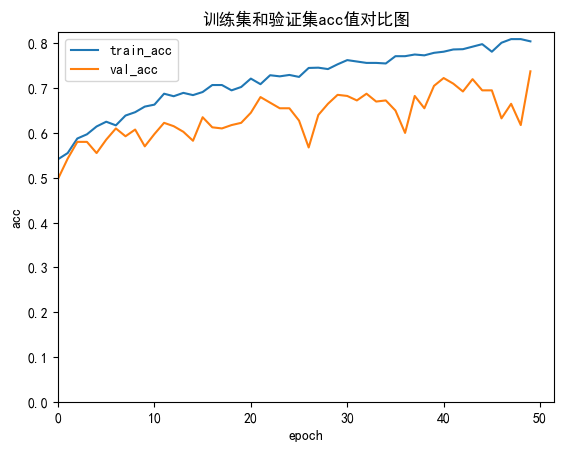


avg_train_loss: 0.4257     avg_train_acc: 0.8060
avg_val_loss: 0.5332     avg_val_acc: 0.7665
Done!


In [21]:
# 开始训练
all_loss_train = [0.0,0.0,0.0,0.0,0.0]
all_acc_train = [0.0,0.0,0.0,0.0,0.0]
all_loss_val = [0.0,0.0,0.0,0.0,0.0]
all_acc_val = [0.0,0.0,0.0,0.0,0.0]

avg_loss_train = 0
avg_acc_train = 0
avg_loss_val = 0
avg_acc_val = 0
#lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

for i in range (5):
#for i in range (1):
    start = time.time()
    #model = Cnn(input_shape).to(device)
    #model = AlexNet(input_shape).to(device)
    #model = DNNModel(input_shape).to(device)
    model_bilinear = Bilinear(input_shape).to(device)
    # 定义一个损失函数
    loss_fn = nn.BCELoss()
    # 定义一个优化器
    optimizer = torch.optim.Adam(model_bilinear.parameters(), lr=1e-4)
    # 学习率每隔10轮变为原来的0.5
    #lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    ROOT_TRAIN = TRAIN_DIRS[i]
    ROOT_TEST = VAL_DIRS[i]
    train_dataset = ImageFolder(ROOT_TRAIN, transform=train_transform)
    val_dataset = ImageFolder(ROOT_TEST, transform=val_transform)

    train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)
    loss_train = []
    acc_train = []
    loss_val = []
    acc_val = []

    epoch = 50
    min_acc = 0
    best_epoch = 0
    for t in range(epoch):
        print(f"epoch{t+1}\n-----------")
        train_loss, train_acc = train(train_dataloader, model_bilinear, loss_fn, optimizer)
        #lr_scheduler.step()
        val_loss, val_acc = val(val_dataloader, model_bilinear, loss_fn)

        loss_train.append(train_loss)
        acc_train.append(train_acc)
        loss_val.append(val_loss)
        acc_val.append(val_acc)

        # 保存最好的模型权重
        if val_acc >min_acc:
            folder = 'save_model'
            if not os.path.exists(folder):
                os.mkdir('save_model')
            all_acc_val[i] = val_acc
            all_loss_val[i] = val_loss
            all_acc_train[i] = train_acc
            all_loss_train[i] = train_loss

            min_acc = val_acc
            print(f"save best model, 第{t+1}轮")
            best_epoch = t
            torch.save(model_bilinear, 'save_model/best_bilinear.pth')
        # 保存最后一轮的权重文件
        if t == epoch-1:
            torch.save(model_bilinear, 'save_model/last_bilinear.pth')

    end = time.time()
    all_time = end-start
    print("all_time",all_time)

    avg_acc_val += all_acc_val[i]
    avg_loss_val += all_loss_val[i]
    avg_acc_train += all_acc_train[i]
    avg_loss_train += all_loss_train[i]

    matplot_loss(loss_train, loss_val)
    matplot_acc(acc_train, acc_val)

print("")
print('avg_train_loss: {:.4f}     avg_train_acc: {:.4f}'.format(avg_loss_train/5, avg_acc_train/5))
print('avg_val_loss: {:.4f}     avg_val_acc: {:.4f}'.format(avg_loss_val/5, avg_acc_val/5))
print('Done!')

epoch1
-----------
train_loss: 0.6909     train_acc: 0.5344
val_loss: 0.6926     val_acc: 0.5125

save best model, 第1轮
epoch2
-----------
train_loss: 0.6827     train_acc: 0.5800
val_loss: 0.6790     val_acc: 0.6250

save best model, 第2轮
epoch3
-----------
train_loss: 0.6690     train_acc: 0.6219
val_loss: 0.6820     val_acc: 0.5700

epoch4
-----------
train_loss: 0.6572     train_acc: 0.6262
val_loss: 0.6376     val_acc: 0.6550

save best model, 第4轮
epoch5
-----------
train_loss: 0.6428     train_acc: 0.6394
val_loss: 0.6175     val_acc: 0.6725

save best model, 第5轮
epoch6
-----------
train_loss: 0.6324     train_acc: 0.6631
val_loss: 0.6094     val_acc: 0.6875

save best model, 第6轮
epoch7
-----------
train_loss: 0.6302     train_acc: 0.6394
val_loss: 0.6089     val_acc: 0.6825

epoch8
-----------
train_loss: 0.6153     train_acc: 0.6644
val_loss: 0.5959     val_acc: 0.6750

epoch9
-----------
train_loss: 0.6137     train_acc: 0.6656
val_loss: 0.5941     val_acc: 0.6925

save best mod

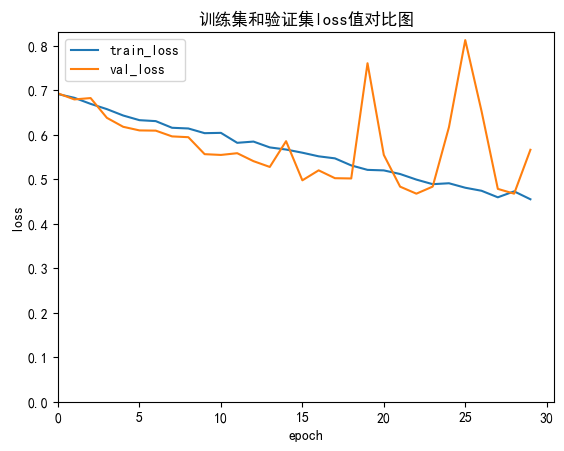

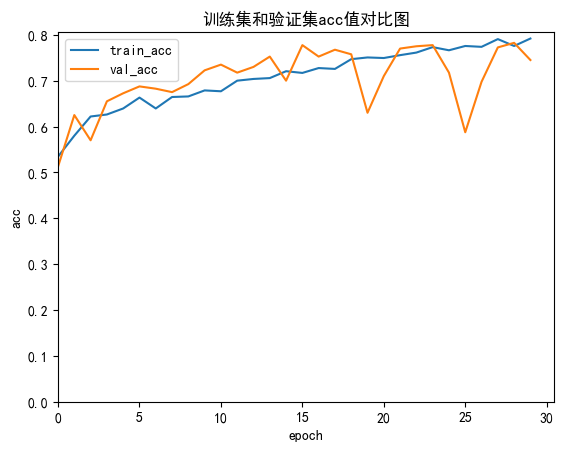

epoch1
-----------
train_loss: 0.6938     train_acc: 0.4994
val_loss: 0.6930     val_acc: 0.4800

save best model, 第1轮
epoch2
-----------
train_loss: 0.6917     train_acc: 0.5250
val_loss: 0.6893     val_acc: 0.5775

save best model, 第2轮
epoch3
-----------
train_loss: 0.6897     train_acc: 0.5419
val_loss: 0.6853     val_acc: 0.5675

epoch4
-----------
train_loss: 0.6829     train_acc: 0.5719
val_loss: 0.6804     val_acc: 0.5825

save best model, 第4轮
epoch5
-----------
train_loss: 0.6972     train_acc: 0.5019
val_loss: 0.6939     val_acc: 0.5000

epoch6
-----------
train_loss: 0.6928     train_acc: 0.5088
val_loss: 0.6896     val_acc: 0.5575

epoch7
-----------
train_loss: 0.6881     train_acc: 0.5594
val_loss: 0.6846     val_acc: 0.5675

epoch8
-----------
train_loss: 0.6826     train_acc: 0.5650
val_loss: 0.6796     val_acc: 0.5925

save best model, 第8轮
epoch9
-----------
train_loss: 0.6791     train_acc: 0.5781
val_loss: 0.6819     val_acc: 0.5675

epoch10
-----------
train_loss: 0.

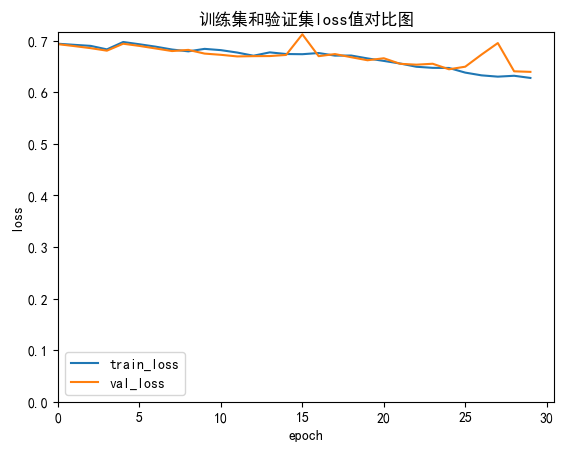

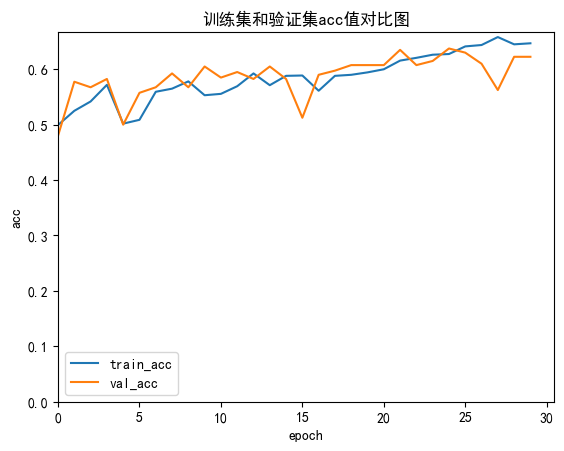

epoch1
-----------
train_loss: 0.6909     train_acc: 0.5356
val_loss: 0.6941     val_acc: 0.5000

save best model, 第1轮
epoch2
-----------
train_loss: 0.6843     train_acc: 0.5794
val_loss: 0.6827     val_acc: 0.5900

save best model, 第2轮
epoch3
-----------
train_loss: 0.6844     train_acc: 0.5669
val_loss: 0.6836     val_acc: 0.5850

epoch4
-----------
train_loss: 0.6807     train_acc: 0.5813
val_loss: 0.7079     val_acc: 0.5000

epoch5
-----------
train_loss: 0.6794     train_acc: 0.5856
val_loss: 0.6906     val_acc: 0.5350

epoch6
-----------
train_loss: 0.6665     train_acc: 0.6081
val_loss: 0.6780     val_acc: 0.6000

save best model, 第6轮
epoch7
-----------
train_loss: 0.6599     train_acc: 0.6206
val_loss: 0.6962     val_acc: 0.5525

epoch8
-----------
train_loss: 0.6448     train_acc: 0.6444
val_loss: 0.6592     val_acc: 0.5925

epoch9
-----------
train_loss: 0.6333     train_acc: 0.6544
val_loss: 0.6855     val_acc: 0.5975

epoch10
-----------
train_loss: 0.6301     train_acc: 0

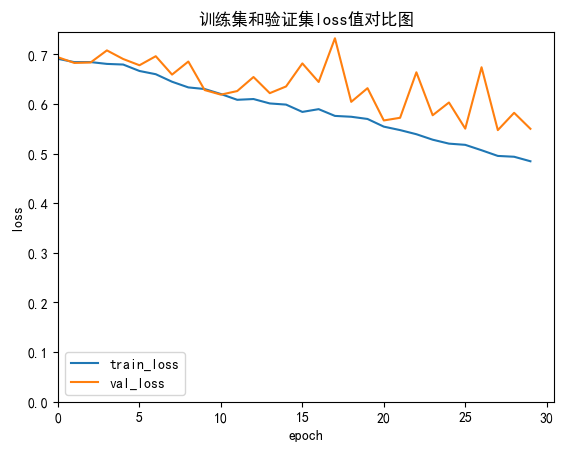

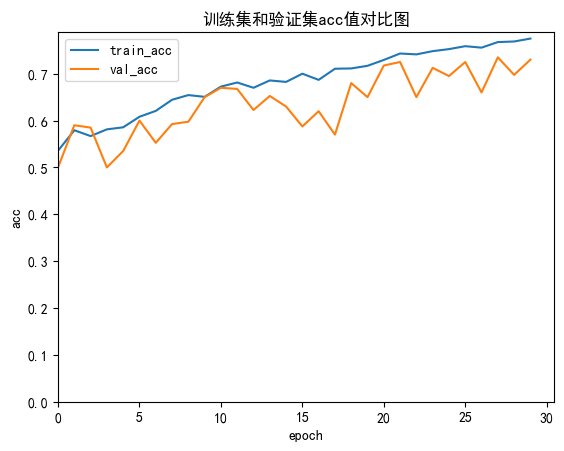

epoch1
-----------
train_loss: 0.6918     train_acc: 0.5288
val_loss: 0.6960     val_acc: 0.4725

save best model, 第1轮
epoch2
-----------
train_loss: 0.6848     train_acc: 0.5775
val_loss: 0.6962     val_acc: 0.5200

save best model, 第2轮
epoch3
-----------
train_loss: 0.6789     train_acc: 0.5831
val_loss: 0.6944     val_acc: 0.5100

epoch4
-----------
train_loss: 0.6870     train_acc: 0.5363
val_loss: 0.6830     val_acc: 0.5650

save best model, 第4轮
epoch5
-----------
train_loss: 0.6847     train_acc: 0.5556
val_loss: 0.6855     val_acc: 0.5775

save best model, 第5轮
epoch6
-----------
train_loss: 0.6734     train_acc: 0.5819
val_loss: 0.6908     val_acc: 0.5200

epoch7
-----------
train_loss: 0.6695     train_acc: 0.5938
val_loss: 0.6867     val_acc: 0.5300

epoch8
-----------
train_loss: 0.6723     train_acc: 0.5825
val_loss: 0.6753     val_acc: 0.5775

epoch9
-----------
train_loss: 0.6590     train_acc: 0.6075
val_loss: 0.6588     val_acc: 0.6150

save best model, 第9轮
epoch10
-----

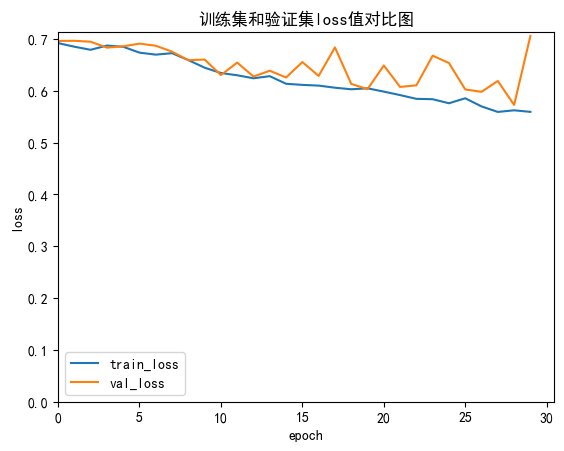

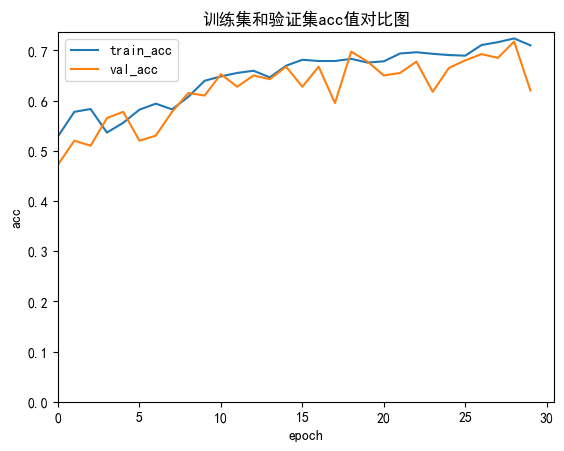

epoch1
-----------
train_loss: 0.6903     train_acc: 0.5606
val_loss: 0.6940     val_acc: 0.5000

save best model, 第1轮
epoch2
-----------
train_loss: 0.6850     train_acc: 0.5669
val_loss: 0.6938     val_acc: 0.5000

epoch3
-----------
train_loss: 0.6714     train_acc: 0.5981
val_loss: 0.6955     val_acc: 0.5325

save best model, 第3轮
epoch4
-----------
train_loss: 0.6565     train_acc: 0.6206
val_loss: 0.6855     val_acc: 0.5700

save best model, 第4轮
epoch5
-----------
train_loss: 0.6383     train_acc: 0.6456
val_loss: 0.6663     val_acc: 0.5950

save best model, 第5轮
epoch6
-----------
train_loss: 0.6268     train_acc: 0.6675
val_loss: 0.6998     val_acc: 0.5625

epoch7
-----------
train_loss: 0.6147     train_acc: 0.6725
val_loss: 0.6943     val_acc: 0.5900

epoch8
-----------
train_loss: 0.6124     train_acc: 0.6719
val_loss: 0.6730     val_acc: 0.6050

save best model, 第8轮
epoch9
-----------
train_loss: 0.6034     train_acc: 0.6813
val_loss: 0.6776     val_acc: 0.6300

save best mod

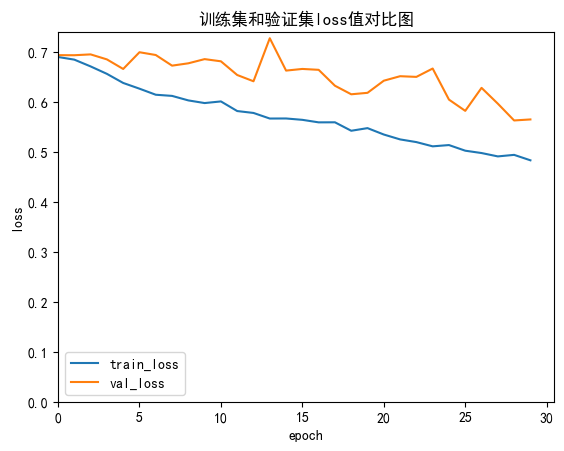

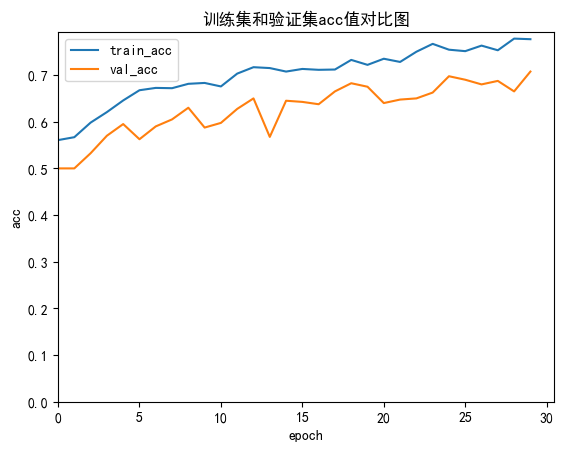


avg_train_loss: 0.5320     avg_train_acc: 0.7342
avg_val_loss: 0.5593     avg_val_acc: 0.7160
Done!


In [10]:
# 开始训练
all_loss_train = [0.0,0.0,0.0,0.0,0.0]
all_acc_train = [0.0,0.0,0.0,0.0,0.0]
all_loss_val = [0.0,0.0,0.0,0.0,0.0]
all_acc_val = [0.0,0.0,0.0,0.0,0.0]

avg_loss_train = 0
avg_acc_train = 0
avg_loss_val = 0
avg_acc_val = 0
#lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

for i in range (5):
#for i in range (1):
    start = time.time()
    #model = Cnn(input_shape).to(device)
    #model = AlexNet(input_shape).to(device)
    #model = DNNModel(input_shape).to(device)
    model_bilinear = Bilinear(input_shape).to(device)
    # 定义一个损失函数
    loss_fn = nn.BCELoss()
    # 定义一个优化器
    optimizer = torch.optim.Adam(model_bilinear.parameters(), lr=1e-4)
    # 学习率每隔10轮变为原来的0.5
    #lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    ROOT_TRAIN = TRAIN_DIRS[i]
    ROOT_TEST = VAL_DIRS[i]
    train_dataset = ImageFolder(ROOT_TRAIN, transform=train_transform)
    val_dataset = ImageFolder(ROOT_TEST, transform=val_transform)

    train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)
    loss_train = []
    acc_train = []
    loss_val = []
    acc_val = []

    epoch = 30
    min_acc = 0
    best_epoch = 0
    for t in range(epoch):
        print(f"epoch{t+1}\n-----------")
        train_loss, train_acc = train(train_dataloader, model_bilinear, loss_fn, optimizer)
        #lr_scheduler.step()
        val_loss, val_acc = val(val_dataloader, model_bilinear, loss_fn)

        loss_train.append(train_loss)
        acc_train.append(train_acc)
        loss_val.append(val_loss)
        acc_val.append(val_acc)

        # 保存最好的模型权重
        if val_acc >min_acc:
            folder = 'save_model'
            if not os.path.exists(folder):
                os.mkdir('save_model')
            all_acc_val[i] = val_acc
            all_loss_val[i] = val_loss
            all_acc_train[i] = train_acc
            all_loss_train[i] = train_loss

            min_acc = val_acc
            print(f"save best model, 第{t+1}轮")
            best_epoch = t
            torch.save(model_bilinear, 'save_model/best_bilinear.pth')
        # 保存最后一轮的权重文件
        if t == epoch-1:
            torch.save(model_bilinear, 'save_model/last_bilinear.pth')

    end = time.time()
    all_time = end-start
    print("all_time",all_time)

    avg_acc_val += all_acc_val[i]
    avg_loss_val += all_loss_val[i]
    avg_acc_train += all_acc_train[i]
    avg_loss_train += all_loss_train[i]

    matplot_loss(loss_train, loss_val)
    matplot_acc(acc_train, acc_val)

print("")
print('avg_train_loss: {:.4f}     avg_train_acc: {:.4f}'.format(avg_loss_train/5, avg_acc_train/5))
print('avg_val_loss: {:.4f}     avg_val_acc: {:.4f}'.format(avg_loss_val/5, avg_acc_val/5))
print('Done!')

epoch1
-----------
train_loss: 0.6927     train_acc: 0.5056
val_loss: 0.6904     val_acc: 0.5100

save best model, 第1轮
epoch2
-----------
train_loss: 0.6910     train_acc: 0.5394
val_loss: 0.6870     val_acc: 0.5475

save best model, 第2轮
epoch3
-----------
train_loss: 0.6911     train_acc: 0.5413
val_loss: 0.6893     val_acc: 0.5025

epoch4
-----------
train_loss: 0.6889     train_acc: 0.5569
val_loss: 0.6839     val_acc: 0.5950

save best model, 第4轮
epoch5
-----------
train_loss: 0.6821     train_acc: 0.5637
val_loss: 0.6799     val_acc: 0.5400

epoch6
-----------
train_loss: 0.6838     train_acc: 0.5637
val_loss: 0.6803     val_acc: 0.5575

epoch7
-----------
train_loss: 0.6807     train_acc: 0.5687
val_loss: 0.6800     val_acc: 0.5550

epoch8
-----------
train_loss: 0.6835     train_acc: 0.5587
val_loss: 0.6748     val_acc: 0.5950

epoch9
-----------
train_loss: 0.6810     train_acc: 0.5669
val_loss: 0.6876     val_acc: 0.5100

epoch10
-----------
train_loss: 0.6772     train_acc: 0

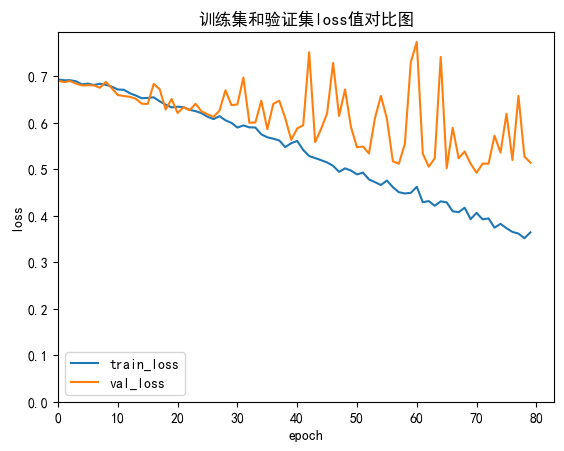

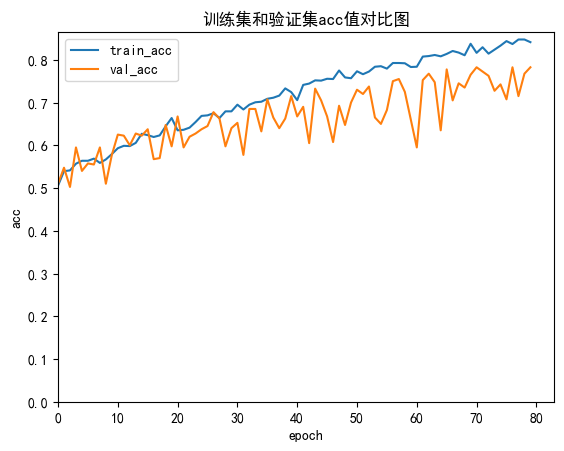

epoch1
-----------
train_loss: 0.6917     train_acc: 0.5262
val_loss: 0.6949     val_acc: 0.5000

save best model, 第1轮
epoch2
-----------
train_loss: 0.6900     train_acc: 0.5413
val_loss: 0.6868     val_acc: 0.5875

save best model, 第2轮
epoch3
-----------
train_loss: 0.6847     train_acc: 0.5625
val_loss: 0.6816     val_acc: 0.5550

epoch4
-----------
train_loss: 0.6820     train_acc: 0.5756
val_loss: 0.6866     val_acc: 0.5350

epoch5
-----------
train_loss: 0.6647     train_acc: 0.6131
val_loss: 0.7044     val_acc: 0.5100

epoch6
-----------
train_loss: 0.6553     train_acc: 0.6262
val_loss: 0.6813     val_acc: 0.5425

epoch7
-----------
train_loss: 0.6558     train_acc: 0.6225
val_loss: 0.6445     val_acc: 0.6300

save best model, 第7轮
epoch8
-----------
train_loss: 0.6429     train_acc: 0.6375
val_loss: 0.6448     val_acc: 0.6450

save best model, 第8轮
epoch9
-----------
train_loss: 0.6317     train_acc: 0.6531
val_loss: 0.6598     val_acc: 0.5950

epoch10
-----------
train_loss: 0.

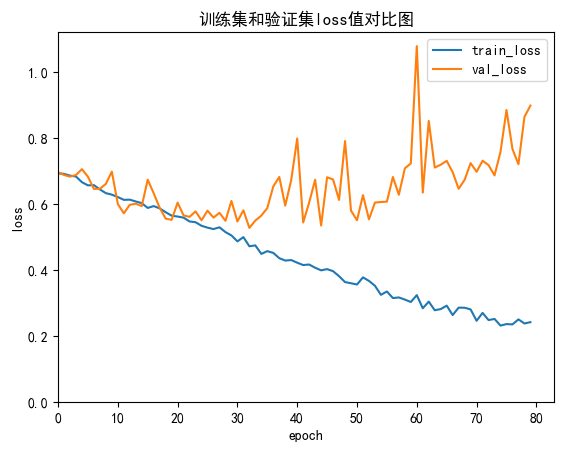

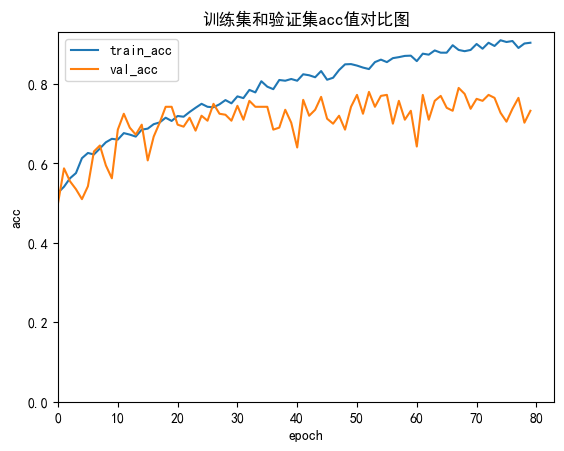

epoch1
-----------
train_loss: 0.6919     train_acc: 0.5238
val_loss: 0.6931     val_acc: 0.5325

save best model, 第1轮
epoch2
-----------
train_loss: 0.6870     train_acc: 0.5569
val_loss: 0.6935     val_acc: 0.5025

epoch3
-----------
train_loss: 0.6867     train_acc: 0.5413
val_loss: 0.6929     val_acc: 0.5075

epoch4
-----------
train_loss: 0.6751     train_acc: 0.5962
val_loss: 0.6639     val_acc: 0.6225

save best model, 第4轮
epoch5
-----------
train_loss: 0.6637     train_acc: 0.6150
val_loss: 0.6798     val_acc: 0.5625

epoch6
-----------
train_loss: 0.6474     train_acc: 0.6350
val_loss: 0.7094     val_acc: 0.5350

epoch7
-----------
train_loss: 0.6392     train_acc: 0.6438
val_loss: 0.6257     val_acc: 0.6750

save best model, 第7轮
epoch8
-----------
train_loss: 0.6306     train_acc: 0.6569
val_loss: 0.6435     val_acc: 0.6150

epoch9
-----------
train_loss: 0.6195     train_acc: 0.6681
val_loss: 0.6652     val_acc: 0.6325

epoch10
-----------
train_loss: 0.6153     train_acc: 0

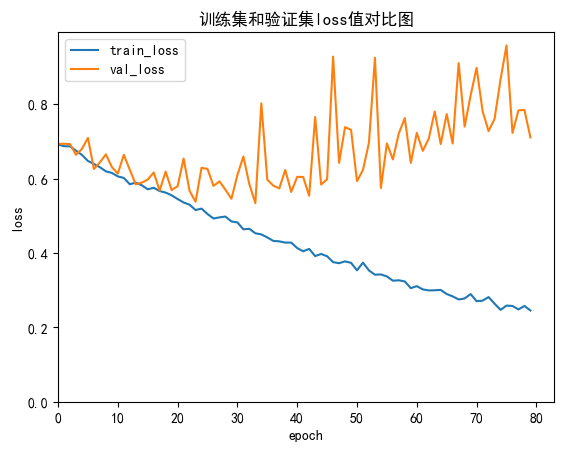

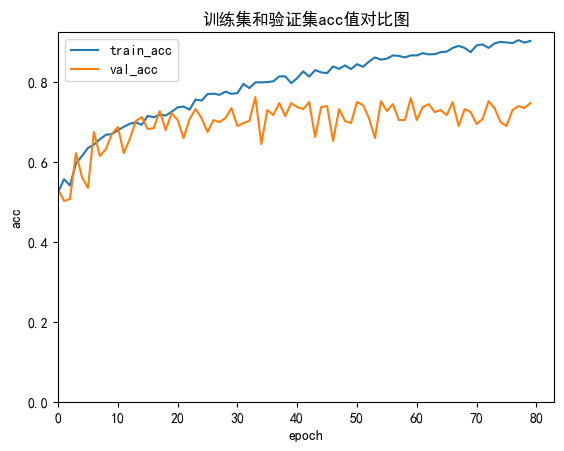

epoch1
-----------
train_loss: 0.6917     train_acc: 0.5150
val_loss: 0.6946     val_acc: 0.4775

save best model, 第1轮
epoch2
-----------
train_loss: 0.6859     train_acc: 0.5700
val_loss: 0.6961     val_acc: 0.5000

save best model, 第2轮
epoch3
-----------
train_loss: 0.6790     train_acc: 0.5919
val_loss: 0.6937     val_acc: 0.5325

save best model, 第3轮
epoch4
-----------
train_loss: 0.6748     train_acc: 0.5900
val_loss: 0.6919     val_acc: 0.5350

save best model, 第4轮
epoch5
-----------
train_loss: 0.6742     train_acc: 0.5813
val_loss: 0.6902     val_acc: 0.5225

epoch6
-----------
train_loss: 0.6770     train_acc: 0.5813
val_loss: 0.6960     val_acc: 0.5200

epoch7
-----------
train_loss: 0.6750     train_acc: 0.5825
val_loss: 0.6861     val_acc: 0.5475

save best model, 第7轮
epoch8
-----------
train_loss: 0.6700     train_acc: 0.5837
val_loss: 0.6917     val_acc: 0.5375

epoch9
-----------
train_loss: 0.6729     train_acc: 0.5831
val_loss: 0.6905     val_acc: 0.5575

save best mod

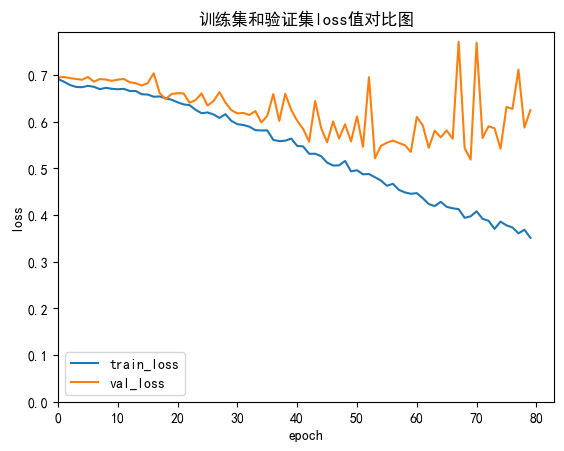

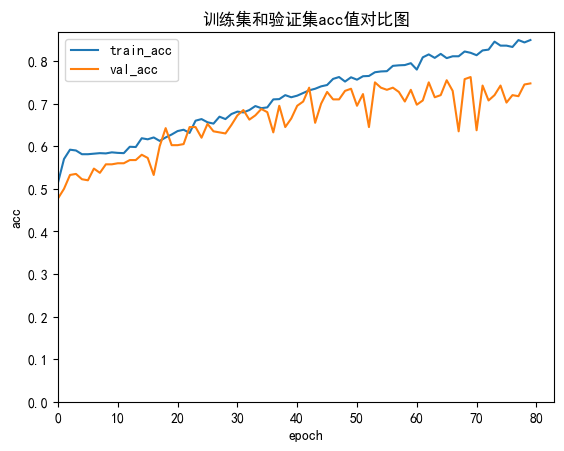

epoch1
-----------
train_loss: 0.6917     train_acc: 0.5262
val_loss: 0.6910     val_acc: 0.5475

save best model, 第1轮
epoch2
-----------
train_loss: 0.6827     train_acc: 0.5863
val_loss: 0.6937     val_acc: 0.5100

epoch3
-----------
train_loss: 0.6697     train_acc: 0.6062
val_loss: 0.6816     val_acc: 0.5650

save best model, 第3轮
epoch4
-----------
train_loss: 0.6559     train_acc: 0.6269
val_loss: 0.6885     val_acc: 0.5500

epoch5
-----------
train_loss: 0.6421     train_acc: 0.6369
val_loss: 0.6723     val_acc: 0.5925

save best model, 第5轮
epoch6
-----------
train_loss: 0.6291     train_acc: 0.6550
val_loss: 0.7218     val_acc: 0.5450

epoch7
-----------
train_loss: 0.6189     train_acc: 0.6669
val_loss: 0.6684     val_acc: 0.5950

save best model, 第7轮
epoch8
-----------
train_loss: 0.6118     train_acc: 0.6781
val_loss: 0.6852     val_acc: 0.5825

epoch9
-----------
train_loss: 0.6105     train_acc: 0.6825
val_loss: 0.6706     val_acc: 0.5950

epoch10
-----------
train_loss: 0.

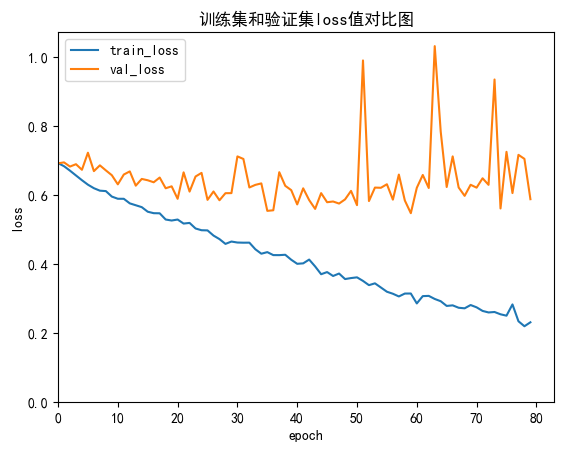

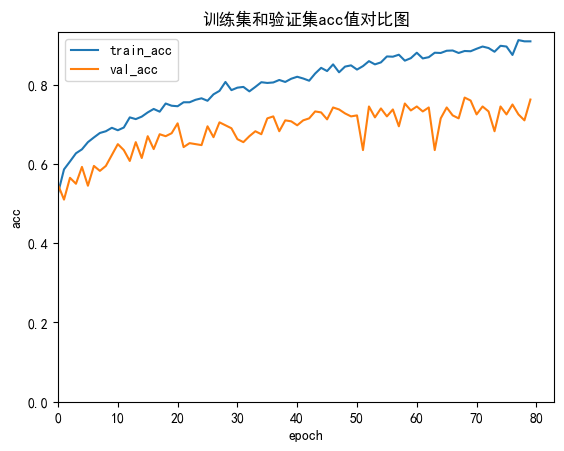


avg_train_loss: 0.3624     avg_train_acc: 0.8411
avg_val_loss: 0.5573     avg_val_acc: 0.7730
Done!


In [11]:
# 开始训练
all_loss_train = [0.0,0.0,0.0,0.0,0.0]
all_acc_train = [0.0,0.0,0.0,0.0,0.0]
all_loss_val = [0.0,0.0,0.0,0.0,0.0]
all_acc_val = [0.0,0.0,0.0,0.0,0.0]

avg_loss_train = 0
avg_acc_train = 0
avg_loss_val = 0
avg_acc_val = 0
#lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

for i in range (5):
#for i in range (1):
    start = time.time()
    #model = Cnn(input_shape).to(device)
    #model = AlexNet(input_shape).to(device)
    #model = DNNModel(input_shape).to(device)
    model_bilinear = Bilinear(input_shape).to(device)
    # 定义一个损失函数
    loss_fn = nn.BCELoss()
    # 定义一个优化器
    optimizer = torch.optim.Adam(model_bilinear.parameters(), lr=1e-4)
    # 学习率每隔10轮变为原来的0.5
    #lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    ROOT_TRAIN = TRAIN_DIRS[i]
    ROOT_TEST = VAL_DIRS[i]
    train_dataset = ImageFolder(ROOT_TRAIN, transform=train_transform)
    val_dataset = ImageFolder(ROOT_TEST, transform=val_transform)

    train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)
    loss_train = []
    acc_train = []
    loss_val = []
    acc_val = []

    epoch = 80
    min_acc = 0
    best_epoch = 0
    for t in range(epoch):
        print(f"epoch{t+1}\n-----------")
        train_loss, train_acc = train(train_dataloader, model_bilinear, loss_fn, optimizer)
        #lr_scheduler.step()
        val_loss, val_acc = val(val_dataloader, model_bilinear, loss_fn)

        loss_train.append(train_loss)
        acc_train.append(train_acc)
        loss_val.append(val_loss)
        acc_val.append(val_acc)

        # 保存最好的模型权重
        if val_acc >min_acc:
            folder = 'save_model'
            if not os.path.exists(folder):
                os.mkdir('save_model')
            all_acc_val[i] = val_acc
            all_loss_val[i] = val_loss
            all_acc_train[i] = train_acc
            all_loss_train[i] = train_loss

            min_acc = val_acc
            print(f"save best model, 第{t+1}轮")
            best_epoch = t
            torch.save(model_bilinear, 'save_model/best_bilinear.pth')
        # 保存最后一轮的权重文件
        if t == epoch-1:
            torch.save(model_bilinear, 'save_model/last_bilinear.pth')

    end = time.time()
    all_time = end-start
    print("all_time",all_time)

    avg_acc_val += all_acc_val[i]
    avg_loss_val += all_loss_val[i]
    avg_acc_train += all_acc_train[i]
    avg_loss_train += all_loss_train[i]

    matplot_loss(loss_train, loss_val)
    matplot_acc(acc_train, acc_val)

print("")
print('avg_train_loss: {:.4f}     avg_train_acc: {:.4f}'.format(avg_loss_train/5, avg_acc_train/5))
print('avg_val_loss: {:.4f}     avg_val_acc: {:.4f}'.format(avg_loss_val/5, avg_acc_val/5))
print('Done!')